# 人脸生成（Face Generation）
在该项目中，你将使用生成式对抗网络（Generative Adversarial Nets）来生成新的人脸图像。
### 获取数据
该项目将使用以下数据集：
- MNIST
- CelebA

由于 CelebA 数据集比较复杂，而且这是你第一次使用 GANs。我们想让你先在 MNIST 数据集上测试你的 GANs 模型，以让你更快的评估所建立模型的性能。

如果你在使用 [FloydHub](https://www.floydhub.com/), 请将 `data_dir` 设置为 "/input" 并使用 [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [21]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## 探索数据（Explore the Data）
### MNIST
[MNIST](http://yann.lecun.com/exdb/mnist/) 是一个手写数字的图像数据集。你可以更改 `show_n_images` 探索此数据集。

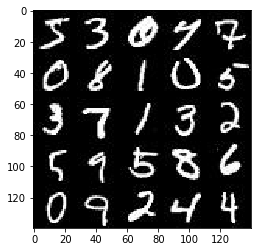

In [22]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
[CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) 是一个包含 20 多万张名人图片及相关图片说明的数据集。你将用此数据集生成人脸，不会用不到相关说明。你可以更改 `show_n_images` 探索此数据集。

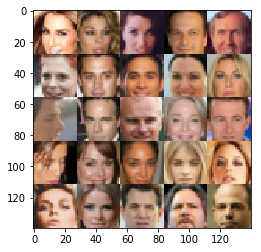

In [23]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## 预处理数据（Preprocess the Data）
由于该项目的重点是建立 GANs 模型，我们将为你预处理数据。

经过数据预处理，MNIST 和 CelebA 数据集的值在 28×28 维度图像的 [-0.5, 0.5] 范围内。CelebA 数据集中的图像裁剪了非脸部的图像部分，然后调整到 28x28 维度。

MNIST 数据集中的图像是单[通道](https://en.wikipedia.org/wiki/Channel_(digital_image%29)的黑白图像，CelebA 数据集中的图像是 [三通道的 RGB 彩色图像](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images)。

## 建立神经网络（Build the Neural Network）
你将通过部署以下函数来建立 GANs 的主要组成部分:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### 检查 TensorFlow 版本并获取 GPU 型号
检查你是否使用正确的 TensorFlow 版本，并获取 GPU 型号

In [24]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0


C:\ProgramData\Anaconda2\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### 输入（Input）
部署 `model_inputs` 函数以创建用于神经网络的 [占位符 (TF Placeholders)](https://www.tensorflow.org/versions/r0.11/api_docs/python/io_ops/placeholders)。请创建以下占位符：
- 输入图像占位符: 使用 `image_width`，`image_height` 和 `image_channels` 设置为 rank 4。
- 输入 Z 占位符: 设置为 rank 2，并命名为 `z_dim`。
- 学习速率占位符: 设置为 rank 0。

返回占位符元组的形状为 (tensor of real input images, tensor of z data, learning rate)。


In [25]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real') 
    input_z = tf.placeholder(tf.float32, (None, z_dim), name="input_z")
    lr = tf.placeholder(tf.float32, name="learning_rate")

    return (input_real, input_z, lr)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### 辨别器（Discriminator）
部署 `discriminator` 函数创建辨别器神经网络以辨别 `images`。该函数应能够重复使用神经网络中的各种变量。 在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "discriminator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回形如 (tensor output of the discriminator, tensor logits of the discriminator) 的元组。

In [26]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        alpha = 0.2
        
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        flat = tf.reshape(relu3, (-1, 4*4*256))
    
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### 生成器（Generator）
部署 `generator` 函数以使用 `z` 生成图像。该函数应能够重复使用神经网络中的各种变量。
在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "generator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回所生成的 28 x 28 x `out_channel_dim` 维度图像。

In [27]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse= not is_train):
        alpha = 0.2
        
        x1 = tf.layers.dense(z, 7 * 7 * 256)
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)

        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same')
        
        out = tf.tanh(logits)
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### 损失函数（Loss）
部署 `model_loss` 函数训练并计算 GANs 的损失。该函数应返回形如 (discriminator loss, generator loss) 的元组。

使用你已实现的函数：
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [28]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    smooth = 0.1
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*(1-smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)*(1-smooth)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)*(1-smooth)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### 优化（Optimization）
部署 `model_opt` 函数实现对 GANs 的优化。使用 [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) 获取可训练的所有变量。通过变量空间名 `discriminator` 和 `generator` 来过滤变量。该函数应返回形如 (discriminator training operation, generator training operation) 的元组。

In [29]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    gen_updates = [opt for opt in update_ops if opt.name.startswith('generator')]
    d_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    with tf.control_dependencies(gen_updates):
        g_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate,beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## 训练神经网络（Neural Network Training）
### 输出显示
使用该函数可以显示生成器 (Generator) 在训练过程中的当前输出，这会帮你评估 GANs 模型的训练程度。

In [30]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### 训练
部署 `train` 函数以建立并训练 GANs 模型。记得使用以下你已完成的函数：
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

使用 `show_generator_output` 函数显示 `generator` 在训练过程中的输出。

**注意**：在每个批次 (batch) 中运行 `show_generator_output` 函数会显著增加训练时间与该 notebook 的体积。推荐每 100 批次输出一次 `generator` 的输出。 

In [31]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    if(data_image_mode == 'RGB'):
        image_channels = 3
    else:
        image_channels = 1
        
    image_width = data_shape[1]
    image_height = data_shape[2]
    
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)    
    d_loss,g_loss = model_loss(input_real, input_z, image_channels)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    batch_num = 0
    samples, losses = [], []
    
    g_vars = [var for var in tf.trainable_variables() if var.name.startswith('generator')]
    saver = tf.train.Saver(var_list=g_vars)  
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                                # Sample random noise for G
                
                # Scale images between -1 and 1
                batch_images *= 2.0
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z})
                batch_num += 1
                
                if (batch_num%100 == 0):
                    show_generator_output(sess=sess,
                                          image_mode=data_image_mode,
                                          input_z=input_z,
                                          n_images=10,
                                          out_channel_dim=image_channels)
            
                # At the end of each epoch, get the losses and print them out
                train_loss_d = sess.run(d_loss, {input_z: batch_z, input_real: batch_images})
                train_loss_g = g_loss.eval({input_z: batch_z})

                print("Epoch {}/{}...".format(epoch_i+1, epochs),
                      "Discriminator Loss: {:.4f}...".format(train_loss_d),
                      "Generator Loss: {:.4f}".format(train_loss_g))    
                # Save losses to view after training
                losses.append((train_loss_d, train_loss_g))

            saver.save(sess, './trainSaver/generator.ckpt')
                

### MNIST
在 MNIST 上测试你的 GANs 模型。经过 2 次迭代，GANs 应该能够生成类似手写数字的图像。确保生成器 (generator) 低于辨别器 (discriminator) 的损失，或接近 0。

Epoch 1/2... Discriminator Loss: 2.7935... Generator Loss: 0.3686
Epoch 1/2... Discriminator Loss: 1.9366... Generator Loss: 0.5898
Epoch 1/2... Discriminator Loss: 0.4210... Generator Loss: 4.0488
Epoch 1/2... Discriminator Loss: 0.4847... Generator Loss: 2.7266
Epoch 1/2... Discriminator Loss: 1.2925... Generator Loss: 0.8898
Epoch 1/2... Discriminator Loss: 2.3503... Generator Loss: 10.6192
Epoch 1/2... Discriminator Loss: 10.1388... Generator Loss: 0.8866
Epoch 1/2... Discriminator Loss: 2.8882... Generator Loss: 0.7424
Epoch 1/2... Discriminator Loss: 2.7571... Generator Loss: 1.9741
Epoch 1/2... Discriminator Loss: 6.9175... Generator Loss: 0.6260
Epoch 1/2... Discriminator Loss: 1.7408... Generator Loss: 4.4026
Epoch 1/2... Discriminator Loss: 1.9572... Generator Loss: 1.1163
Epoch 1/2... Discriminator Loss: 2.2106... Generator Loss: 0.8207
Epoch 1/2... Discriminator Loss: 1.2190... Generator Loss: 8.7819
Epoch 1/2... Discriminator Loss: 0.4917... Generator Loss: 5.0042
Epoch 1/

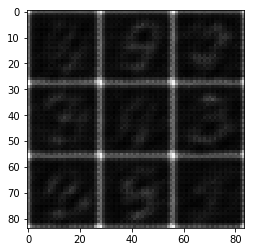

Epoch 1/2... Discriminator Loss: 1.1696... Generator Loss: 1.0189
Epoch 1/2... Discriminator Loss: 1.6378... Generator Loss: 0.4779
Epoch 1/2... Discriminator Loss: 1.6910... Generator Loss: 1.0436
Epoch 1/2... Discriminator Loss: 2.0383... Generator Loss: 0.4103
Epoch 1/2... Discriminator Loss: 1.8198... Generator Loss: 1.4391
Epoch 1/2... Discriminator Loss: 1.7804... Generator Loss: 0.5403
Epoch 1/2... Discriminator Loss: 1.5052... Generator Loss: 0.7058
Epoch 1/2... Discriminator Loss: 1.2868... Generator Loss: 0.7932
Epoch 1/2... Discriminator Loss: 1.4727... Generator Loss: 0.6570
Epoch 1/2... Discriminator Loss: 1.3918... Generator Loss: 0.7198
Epoch 1/2... Discriminator Loss: 1.5496... Generator Loss: 0.5845
Epoch 1/2... Discriminator Loss: 1.4662... Generator Loss: 0.6892
Epoch 1/2... Discriminator Loss: 1.1911... Generator Loss: 0.8126
Epoch 1/2... Discriminator Loss: 1.2403... Generator Loss: 0.7233
Epoch 1/2... Discriminator Loss: 1.2136... Generator Loss: 0.9542
Epoch 1/2.

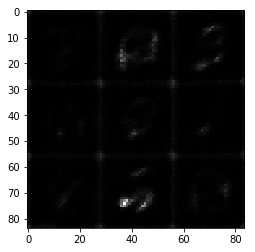

Epoch 1/2... Discriminator Loss: 1.5796... Generator Loss: 0.4941
Epoch 1/2... Discriminator Loss: 1.0927... Generator Loss: 1.2626
Epoch 1/2... Discriminator Loss: 1.2176... Generator Loss: 0.6800
Epoch 1/2... Discriminator Loss: 1.0594... Generator Loss: 1.1616
Epoch 1/2... Discriminator Loss: 1.3126... Generator Loss: 0.6414
Epoch 1/2... Discriminator Loss: 1.0335... Generator Loss: 1.0504
Epoch 1/2... Discriminator Loss: 1.3147... Generator Loss: 0.7285
Epoch 1/2... Discriminator Loss: 1.2377... Generator Loss: 0.7237
Epoch 1/2... Discriminator Loss: 1.0914... Generator Loss: 0.8768
Epoch 1/2... Discriminator Loss: 1.0633... Generator Loss: 0.8246
Epoch 1/2... Discriminator Loss: 1.3249... Generator Loss: 0.6687
Epoch 1/2... Discriminator Loss: 1.2123... Generator Loss: 1.4256
Epoch 1/2... Discriminator Loss: 1.6076... Generator Loss: 0.4814
Epoch 1/2... Discriminator Loss: 1.3195... Generator Loss: 1.3259
Epoch 1/2... Discriminator Loss: 1.7307... Generator Loss: 0.4211
Epoch 1/2.

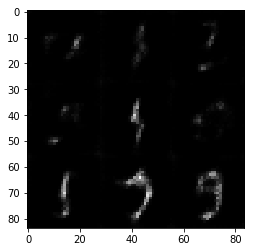

Epoch 1/2... Discriminator Loss: 1.6990... Generator Loss: 0.4921
Epoch 1/2... Discriminator Loss: 1.3977... Generator Loss: 1.0018
Epoch 1/2... Discriminator Loss: 1.2488... Generator Loss: 0.8263
Epoch 1/2... Discriminator Loss: 1.4801... Generator Loss: 0.5042
Epoch 1/2... Discriminator Loss: 1.1983... Generator Loss: 1.3523
Epoch 1/2... Discriminator Loss: 1.5666... Generator Loss: 0.4929
Epoch 1/2... Discriminator Loss: 1.4757... Generator Loss: 0.6592
Epoch 1/2... Discriminator Loss: 1.3121... Generator Loss: 0.9345
Epoch 1/2... Discriminator Loss: 1.5794... Generator Loss: 0.4810
Epoch 1/2... Discriminator Loss: 1.3110... Generator Loss: 1.1947
Epoch 1/2... Discriminator Loss: 1.3038... Generator Loss: 0.5866
Epoch 1/2... Discriminator Loss: 1.2716... Generator Loss: 0.9884
Epoch 1/2... Discriminator Loss: 1.3037... Generator Loss: 0.6681
Epoch 1/2... Discriminator Loss: 1.1714... Generator Loss: 0.7623
Epoch 1/2... Discriminator Loss: 1.1337... Generator Loss: 0.8753
Epoch 1/2.

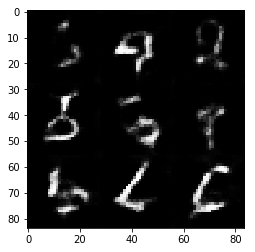

Epoch 1/2... Discriminator Loss: 1.6569... Generator Loss: 0.4418
Epoch 1/2... Discriminator Loss: 1.2617... Generator Loss: 0.9575
Epoch 1/2... Discriminator Loss: 1.3652... Generator Loss: 0.6124
Epoch 1/2... Discriminator Loss: 1.2923... Generator Loss: 0.6634
Epoch 1/2... Discriminator Loss: 1.2063... Generator Loss: 1.4533
Epoch 1/2... Discriminator Loss: 1.4666... Generator Loss: 0.5521
Epoch 1/2... Discriminator Loss: 1.2003... Generator Loss: 1.0036
Epoch 1/2... Discriminator Loss: 1.3314... Generator Loss: 0.6046
Epoch 1/2... Discriminator Loss: 1.0813... Generator Loss: 1.3351
Epoch 1/2... Discriminator Loss: 1.6570... Generator Loss: 0.4620
Epoch 1/2... Discriminator Loss: 1.3670... Generator Loss: 0.9494
Epoch 1/2... Discriminator Loss: 1.2946... Generator Loss: 0.7485
Epoch 1/2... Discriminator Loss: 1.3369... Generator Loss: 0.7019
Epoch 1/2... Discriminator Loss: 1.1694... Generator Loss: 1.2014
Epoch 1/2... Discriminator Loss: 1.6181... Generator Loss: 0.5034
Epoch 1/2.

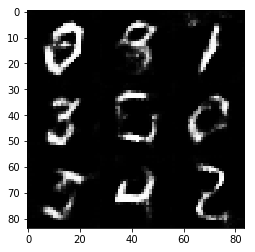

Epoch 1/2... Discriminator Loss: 1.4354... Generator Loss: 0.5363
Epoch 1/2... Discriminator Loss: 1.2424... Generator Loss: 1.1535
Epoch 1/2... Discriminator Loss: 1.3766... Generator Loss: 0.5725
Epoch 1/2... Discriminator Loss: 1.0487... Generator Loss: 1.0676
Epoch 1/2... Discriminator Loss: 1.1887... Generator Loss: 0.9801
Epoch 1/2... Discriminator Loss: 1.2243... Generator Loss: 0.7914
Epoch 1/2... Discriminator Loss: 1.0851... Generator Loss: 0.9286
Epoch 1/2... Discriminator Loss: 1.2277... Generator Loss: 0.7029
Epoch 1/2... Discriminator Loss: 1.2016... Generator Loss: 0.7383
Epoch 1/2... Discriminator Loss: 1.3621... Generator Loss: 0.6697
Epoch 1/2... Discriminator Loss: 1.4152... Generator Loss: 0.5954
Epoch 1/2... Discriminator Loss: 1.4852... Generator Loss: 1.4299
Epoch 1/2... Discriminator Loss: 1.6245... Generator Loss: 0.4841
Epoch 1/2... Discriminator Loss: 1.2092... Generator Loss: 1.2391
Epoch 1/2... Discriminator Loss: 1.2403... Generator Loss: 0.7194
Epoch 1/2.

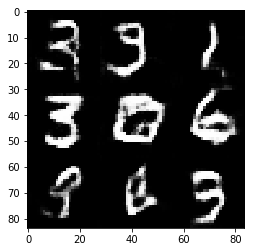

Epoch 1/2... Discriminator Loss: 1.0998... Generator Loss: 0.9038
Epoch 1/2... Discriminator Loss: 1.0791... Generator Loss: 1.1000
Epoch 1/2... Discriminator Loss: 1.3523... Generator Loss: 0.5960
Epoch 1/2... Discriminator Loss: 1.0993... Generator Loss: 1.3030
Epoch 1/2... Discriminator Loss: 1.4508... Generator Loss: 0.5894
Epoch 1/2... Discriminator Loss: 1.0618... Generator Loss: 0.9138
Epoch 1/2... Discriminator Loss: 1.1995... Generator Loss: 0.9715
Epoch 1/2... Discriminator Loss: 0.9833... Generator Loss: 0.9900
Epoch 1/2... Discriminator Loss: 1.2647... Generator Loss: 0.6263
Epoch 1/2... Discriminator Loss: 1.1907... Generator Loss: 0.9629
Epoch 1/2... Discriminator Loss: 1.2296... Generator Loss: 0.7381
Epoch 1/2... Discriminator Loss: 1.1840... Generator Loss: 0.8406
Epoch 1/2... Discriminator Loss: 1.1059... Generator Loss: 0.9056
Epoch 1/2... Discriminator Loss: 1.2147... Generator Loss: 0.8517
Epoch 1/2... Discriminator Loss: 1.2347... Generator Loss: 0.6761
Epoch 1/2.

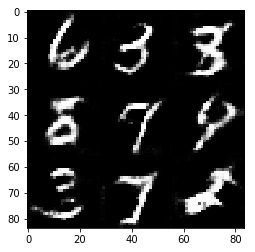

Epoch 1/2... Discriminator Loss: 1.1491... Generator Loss: 0.8004
Epoch 1/2... Discriminator Loss: 1.0489... Generator Loss: 0.8370
Epoch 1/2... Discriminator Loss: 1.5503... Generator Loss: 0.4942
Epoch 1/2... Discriminator Loss: 1.0752... Generator Loss: 1.0950
Epoch 1/2... Discriminator Loss: 1.1236... Generator Loss: 0.8468
Epoch 1/2... Discriminator Loss: 1.0067... Generator Loss: 1.1919
Epoch 1/2... Discriminator Loss: 1.1130... Generator Loss: 0.9536
Epoch 1/2... Discriminator Loss: 1.4444... Generator Loss: 0.5924
Epoch 1/2... Discriminator Loss: 1.1007... Generator Loss: 1.4576
Epoch 1/2... Discriminator Loss: 1.0798... Generator Loss: 0.8097
Epoch 1/2... Discriminator Loss: 1.6364... Generator Loss: 0.4527
Epoch 1/2... Discriminator Loss: 1.2216... Generator Loss: 1.2830
Epoch 1/2... Discriminator Loss: 1.1222... Generator Loss: 0.9430
Epoch 1/2... Discriminator Loss: 1.1889... Generator Loss: 0.7484
Epoch 1/2... Discriminator Loss: 1.1220... Generator Loss: 1.1119
Epoch 1/2.

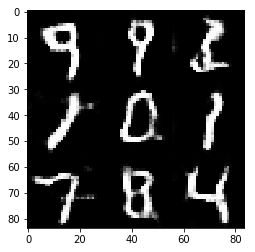

Epoch 1/2... Discriminator Loss: 1.1967... Generator Loss: 0.7321
Epoch 1/2... Discriminator Loss: 1.0832... Generator Loss: 1.4486
Epoch 1/2... Discriminator Loss: 1.1781... Generator Loss: 0.9198
Epoch 1/2... Discriminator Loss: 1.1492... Generator Loss: 0.7540
Epoch 1/2... Discriminator Loss: 1.0142... Generator Loss: 1.0864
Epoch 1/2... Discriminator Loss: 1.0312... Generator Loss: 0.9864
Epoch 1/2... Discriminator Loss: 1.5866... Generator Loss: 0.4800
Epoch 1/2... Discriminator Loss: 1.2650... Generator Loss: 1.6521
Epoch 1/2... Discriminator Loss: 1.2630... Generator Loss: 0.6394
Epoch 1/2... Discriminator Loss: 1.0478... Generator Loss: 1.0385
Epoch 1/2... Discriminator Loss: 0.9262... Generator Loss: 0.9764
Epoch 1/2... Discriminator Loss: 1.1199... Generator Loss: 0.8846
Epoch 1/2... Discriminator Loss: 1.2911... Generator Loss: 0.6017
Epoch 1/2... Discriminator Loss: 0.9859... Generator Loss: 1.1201
Epoch 1/2... Discriminator Loss: 1.1366... Generator Loss: 0.7958
Epoch 1/2.

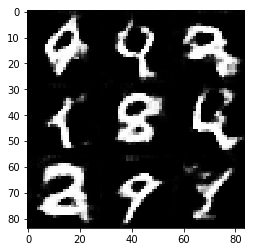

Epoch 1/2... Discriminator Loss: 1.1865... Generator Loss: 0.7048
Epoch 1/2... Discriminator Loss: 1.1814... Generator Loss: 0.7344
Epoch 1/2... Discriminator Loss: 0.9862... Generator Loss: 1.1497
Epoch 1/2... Discriminator Loss: 1.4881... Generator Loss: 0.5215
Epoch 1/2... Discriminator Loss: 0.9989... Generator Loss: 1.1109
Epoch 1/2... Discriminator Loss: 1.0539... Generator Loss: 0.8268
Epoch 1/2... Discriminator Loss: 1.1190... Generator Loss: 0.8855
Epoch 1/2... Discriminator Loss: 1.2412... Generator Loss: 0.6682
Epoch 1/2... Discriminator Loss: 1.0217... Generator Loss: 1.1707
Epoch 1/2... Discriminator Loss: 1.4893... Generator Loss: 0.5622
Epoch 1/2... Discriminator Loss: 1.0337... Generator Loss: 1.5117
Epoch 1/2... Discriminator Loss: 1.5096... Generator Loss: 0.5508
Epoch 1/2... Discriminator Loss: 1.0784... Generator Loss: 1.9521
Epoch 1/2... Discriminator Loss: 1.4858... Generator Loss: 0.5389
Epoch 1/2... Discriminator Loss: 1.0208... Generator Loss: 1.0582
Epoch 1/2.

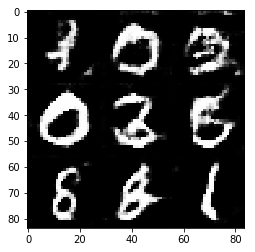

Epoch 1/2... Discriminator Loss: 1.3117... Generator Loss: 0.5864
Epoch 1/2... Discriminator Loss: 1.0372... Generator Loss: 0.9302
Epoch 1/2... Discriminator Loss: 0.8572... Generator Loss: 1.0174
Epoch 1/2... Discriminator Loss: 1.0266... Generator Loss: 0.8557
Epoch 1/2... Discriminator Loss: 0.9470... Generator Loss: 0.9571
Epoch 1/2... Discriminator Loss: 0.9017... Generator Loss: 1.3855
Epoch 1/2... Discriminator Loss: 1.1947... Generator Loss: 0.6651
Epoch 1/2... Discriminator Loss: 0.9599... Generator Loss: 1.1673
Epoch 1/2... Discriminator Loss: 1.2859... Generator Loss: 0.6298
Epoch 1/2... Discriminator Loss: 1.0797... Generator Loss: 0.8681
Epoch 1/2... Discriminator Loss: 1.0349... Generator Loss: 0.8320
Epoch 1/2... Discriminator Loss: 1.0680... Generator Loss: 0.9206
Epoch 1/2... Discriminator Loss: 1.5699... Generator Loss: 0.5317
Epoch 1/2... Discriminator Loss: 1.7174... Generator Loss: 2.6234
Epoch 1/2... Discriminator Loss: 1.7695... Generator Loss: 0.5218
Epoch 1/2.

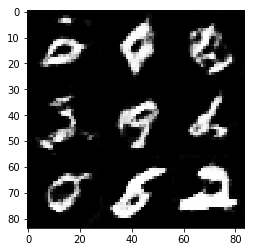

Epoch 1/2... Discriminator Loss: 1.1742... Generator Loss: 0.7088
Epoch 1/2... Discriminator Loss: 1.3364... Generator Loss: 0.6442
Epoch 1/2... Discriminator Loss: 0.9175... Generator Loss: 1.3742
Epoch 1/2... Discriminator Loss: 1.1541... Generator Loss: 0.7473
Epoch 1/2... Discriminator Loss: 1.0554... Generator Loss: 0.7904
Epoch 1/2... Discriminator Loss: 1.0651... Generator Loss: 0.7968
Epoch 1/2... Discriminator Loss: 1.0249... Generator Loss: 0.9956
Epoch 1/2... Discriminator Loss: 1.3166... Generator Loss: 0.5781
Epoch 1/2... Discriminator Loss: 1.0341... Generator Loss: 0.9279
Epoch 1/2... Discriminator Loss: 1.0412... Generator Loss: 0.9047
Epoch 1/2... Discriminator Loss: 1.3005... Generator Loss: 0.6266
Epoch 1/2... Discriminator Loss: 1.0544... Generator Loss: 0.9480
Epoch 1/2... Discriminator Loss: 1.5792... Generator Loss: 0.4868
Epoch 1/2... Discriminator Loss: 1.1672... Generator Loss: 1.8266
Epoch 1/2... Discriminator Loss: 1.6694... Generator Loss: 0.4624
Epoch 1/2.

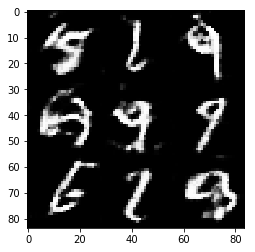

Epoch 1/2... Discriminator Loss: 0.9981... Generator Loss: 0.9887
Epoch 1/2... Discriminator Loss: 1.1671... Generator Loss: 0.7607
Epoch 1/2... Discriminator Loss: 0.9045... Generator Loss: 1.0360
Epoch 1/2... Discriminator Loss: 1.1064... Generator Loss: 0.7839
Epoch 1/2... Discriminator Loss: 0.8521... Generator Loss: 1.2133
Epoch 1/2... Discriminator Loss: 0.8053... Generator Loss: 1.2052
Epoch 1/2... Discriminator Loss: 1.1522... Generator Loss: 0.8062
Epoch 1/2... Discriminator Loss: 0.9621... Generator Loss: 0.9743
Epoch 1/2... Discriminator Loss: 0.8002... Generator Loss: 1.1532
Epoch 1/2... Discriminator Loss: 0.7624... Generator Loss: 1.7106
Epoch 1/2... Discriminator Loss: 1.1598... Generator Loss: 0.7559
Epoch 1/2... Discriminator Loss: 0.9297... Generator Loss: 0.9758
Epoch 1/2... Discriminator Loss: 0.8589... Generator Loss: 1.5267
Epoch 1/2... Discriminator Loss: 1.0393... Generator Loss: 0.8273
Epoch 1/2... Discriminator Loss: 0.8842... Generator Loss: 1.2798
Epoch 1/2.

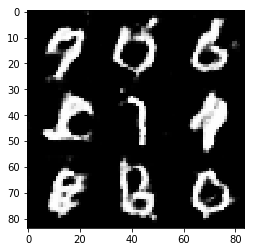

Epoch 1/2... Discriminator Loss: 1.0713... Generator Loss: 0.8025
Epoch 1/2... Discriminator Loss: 1.0032... Generator Loss: 1.0840
Epoch 1/2... Discriminator Loss: 1.1605... Generator Loss: 0.6909
Epoch 1/2... Discriminator Loss: 1.0410... Generator Loss: 0.8765
Epoch 1/2... Discriminator Loss: 1.1417... Generator Loss: 0.7429
Epoch 1/2... Discriminator Loss: 0.8950... Generator Loss: 1.1390
Epoch 1/2... Discriminator Loss: 1.2842... Generator Loss: 0.6339
Epoch 1/2... Discriminator Loss: 1.0848... Generator Loss: 1.6074
Epoch 1/2... Discriminator Loss: 1.5508... Generator Loss: 0.5871
Epoch 1/2... Discriminator Loss: 1.3594... Generator Loss: 1.3550
Epoch 1/2... Discriminator Loss: 1.6695... Generator Loss: 0.5263
Epoch 1/2... Discriminator Loss: 1.1986... Generator Loss: 2.0184
Epoch 1/2... Discriminator Loss: 1.9807... Generator Loss: 0.4028
Epoch 1/2... Discriminator Loss: 1.1964... Generator Loss: 1.9592
Epoch 1/2... Discriminator Loss: 1.1124... Generator Loss: 0.7725
Epoch 1/2.

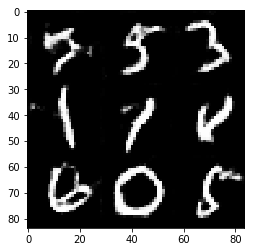

Epoch 1/2... Discriminator Loss: 1.8902... Generator Loss: 0.4054
Epoch 1/2... Discriminator Loss: 1.1249... Generator Loss: 1.5285
Epoch 1/2... Discriminator Loss: 1.7315... Generator Loss: 0.4621
Epoch 1/2... Discriminator Loss: 1.0362... Generator Loss: 1.1390
Epoch 1/2... Discriminator Loss: 0.8776... Generator Loss: 1.0546
Epoch 1/2... Discriminator Loss: 0.9419... Generator Loss: 1.1291
Epoch 1/2... Discriminator Loss: 1.0198... Generator Loss: 0.8868
Epoch 1/2... Discriminator Loss: 0.8427... Generator Loss: 1.1862
Epoch 1/2... Discriminator Loss: 1.2120... Generator Loss: 0.6975
Epoch 1/2... Discriminator Loss: 0.9111... Generator Loss: 1.0479
Epoch 1/2... Discriminator Loss: 0.8291... Generator Loss: 1.5294
Epoch 1/2... Discriminator Loss: 1.2127... Generator Loss: 0.7518
Epoch 1/2... Discriminator Loss: 0.8792... Generator Loss: 1.3215
Epoch 1/2... Discriminator Loss: 1.0148... Generator Loss: 0.8716
Epoch 1/2... Discriminator Loss: 0.8806... Generator Loss: 1.1834
Epoch 1/2.

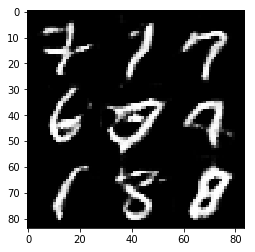

Epoch 1/2... Discriminator Loss: 1.5061... Generator Loss: 0.5948
Epoch 1/2... Discriminator Loss: 1.1018... Generator Loss: 1.4762
Epoch 1/2... Discriminator Loss: 1.3743... Generator Loss: 0.5985
Epoch 1/2... Discriminator Loss: 0.8215... Generator Loss: 1.3099
Epoch 1/2... Discriminator Loss: 0.7798... Generator Loss: 1.2555
Epoch 1/2... Discriminator Loss: 1.0936... Generator Loss: 0.7715
Epoch 1/2... Discriminator Loss: 0.8302... Generator Loss: 1.1906
Epoch 1/2... Discriminator Loss: 1.0138... Generator Loss: 0.8691
Epoch 1/2... Discriminator Loss: 0.9381... Generator Loss: 0.9936
Epoch 1/2... Discriminator Loss: 0.7881... Generator Loss: 1.2349
Epoch 1/2... Discriminator Loss: 1.7297... Generator Loss: 0.4534
Epoch 1/2... Discriminator Loss: 1.0530... Generator Loss: 2.1598
Epoch 1/2... Discriminator Loss: 0.8964... Generator Loss: 0.9946
Epoch 1/2... Discriminator Loss: 1.0804... Generator Loss: 0.8174
Epoch 1/2... Discriminator Loss: 0.7573... Generator Loss: 1.7772
Epoch 1/2.

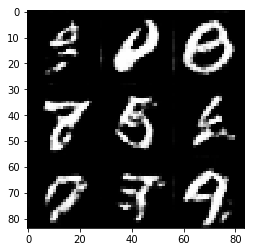

Epoch 1/2... Discriminator Loss: 0.7062... Generator Loss: 1.3854
Epoch 1/2... Discriminator Loss: 0.7632... Generator Loss: 1.2700
Epoch 1/2... Discriminator Loss: 0.9137... Generator Loss: 0.9415
Epoch 1/2... Discriminator Loss: 0.9858... Generator Loss: 0.8929
Epoch 1/2... Discriminator Loss: 0.7836... Generator Loss: 1.1606
Epoch 1/2... Discriminator Loss: 0.6910... Generator Loss: 1.4439
Epoch 1/2... Discriminator Loss: 1.0153... Generator Loss: 0.8643
Epoch 1/2... Discriminator Loss: 0.8406... Generator Loss: 1.1664
Epoch 1/2... Discriminator Loss: 1.5385... Generator Loss: 0.6351
Epoch 1/2... Discriminator Loss: 1.0016... Generator Loss: 1.7180
Epoch 1/2... Discriminator Loss: 1.7147... Generator Loss: 0.4887
Epoch 1/2... Discriminator Loss: 1.1988... Generator Loss: 2.1407
Epoch 1/2... Discriminator Loss: 1.6682... Generator Loss: 0.6035
Epoch 1/2... Discriminator Loss: 0.8752... Generator Loss: 1.5066
Epoch 1/2... Discriminator Loss: 1.7032... Generator Loss: 0.5388
Epoch 1/2.

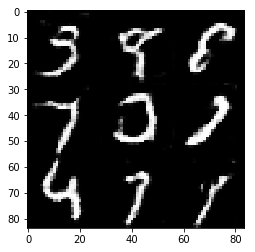

Epoch 1/2... Discriminator Loss: 0.9186... Generator Loss: 1.0075
Epoch 1/2... Discriminator Loss: 0.7766... Generator Loss: 1.3564
Epoch 1/2... Discriminator Loss: 0.6041... Generator Loss: 1.7578
Epoch 1/2... Discriminator Loss: 0.7415... Generator Loss: 1.3577
Epoch 1/2... Discriminator Loss: 0.6186... Generator Loss: 1.5119
Epoch 1/2... Discriminator Loss: 0.7511... Generator Loss: 1.2126
Epoch 1/2... Discriminator Loss: 0.8307... Generator Loss: 1.1014
Epoch 1/2... Discriminator Loss: 0.7941... Generator Loss: 1.2904
Epoch 1/2... Discriminator Loss: 1.0717... Generator Loss: 0.8872
Epoch 1/2... Discriminator Loss: 0.8752... Generator Loss: 0.9840
Epoch 1/2... Discriminator Loss: 0.8309... Generator Loss: 1.9909
Epoch 1/2... Discriminator Loss: 1.6112... Generator Loss: 0.5948
Epoch 1/2... Discriminator Loss: 0.9666... Generator Loss: 1.2166
Epoch 1/2... Discriminator Loss: 1.2202... Generator Loss: 0.7942
Epoch 1/2... Discriminator Loss: 1.9788... Generator Loss: 0.4144
Epoch 1/2.

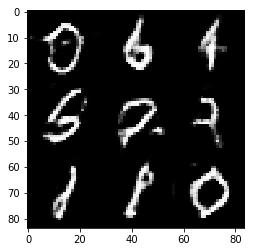

Epoch 1/2... Discriminator Loss: 0.7436... Generator Loss: 1.2277
Epoch 1/2... Discriminator Loss: 1.1836... Generator Loss: 0.6886
Epoch 1/2... Discriminator Loss: 1.1083... Generator Loss: 0.7758
Epoch 1/2... Discriminator Loss: 0.8390... Generator Loss: 1.5431
Epoch 1/2... Discriminator Loss: 0.9929... Generator Loss: 0.9135
Epoch 1/2... Discriminator Loss: 1.0772... Generator Loss: 0.7585
Epoch 1/2... Discriminator Loss: 0.9127... Generator Loss: 1.9732
Epoch 1/2... Discriminator Loss: 0.9662... Generator Loss: 0.8702
Epoch 1/2... Discriminator Loss: 0.7637... Generator Loss: 1.3541
Epoch 1/2... Discriminator Loss: 1.3217... Generator Loss: 0.6501
Epoch 1/2... Discriminator Loss: 0.6905... Generator Loss: 1.5747
Epoch 1/2... Discriminator Loss: 0.9284... Generator Loss: 0.9028
Epoch 1/2... Discriminator Loss: 0.8379... Generator Loss: 1.2807
Epoch 1/2... Discriminator Loss: 0.9147... Generator Loss: 0.8869
Epoch 1/2... Discriminator Loss: 1.0819... Generator Loss: 0.7573
Epoch 1/2.

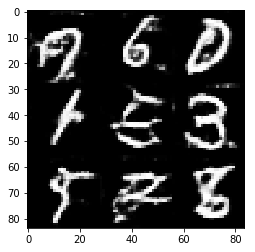

Epoch 2/2... Discriminator Loss: 0.8556... Generator Loss: 1.1709
Epoch 2/2... Discriminator Loss: 0.8631... Generator Loss: 1.0000
Epoch 2/2... Discriminator Loss: 1.1237... Generator Loss: 0.7088
Epoch 2/2... Discriminator Loss: 0.9072... Generator Loss: 1.2444
Epoch 2/2... Discriminator Loss: 0.7726... Generator Loss: 1.2134
Epoch 2/2... Discriminator Loss: 0.9902... Generator Loss: 0.8723
Epoch 2/2... Discriminator Loss: 0.7349... Generator Loss: 1.4516
Epoch 2/2... Discriminator Loss: 0.8022... Generator Loss: 1.1959
Epoch 2/2... Discriminator Loss: 1.3653... Generator Loss: 0.6071
Epoch 2/2... Discriminator Loss: 0.8993... Generator Loss: 1.0579
Epoch 2/2... Discriminator Loss: 0.8598... Generator Loss: 1.0962
Epoch 2/2... Discriminator Loss: 1.0851... Generator Loss: 0.8482
Epoch 2/2... Discriminator Loss: 0.8074... Generator Loss: 2.2467
Epoch 2/2... Discriminator Loss: 1.1653... Generator Loss: 0.7995
Epoch 2/2... Discriminator Loss: 0.8989... Generator Loss: 1.0567
Epoch 2/2.

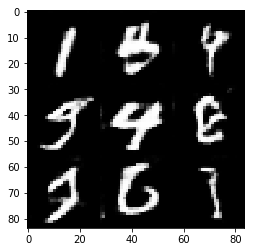

Epoch 2/2... Discriminator Loss: 1.0108... Generator Loss: 1.5101
Epoch 2/2... Discriminator Loss: 1.4535... Generator Loss: 0.5524
Epoch 2/2... Discriminator Loss: 1.1478... Generator Loss: 0.9929
Epoch 2/2... Discriminator Loss: 1.3190... Generator Loss: 0.6878
Epoch 2/2... Discriminator Loss: 1.3338... Generator Loss: 2.0730
Epoch 2/2... Discriminator Loss: 1.3587... Generator Loss: 0.6567
Epoch 2/2... Discriminator Loss: 1.0206... Generator Loss: 0.8532
Epoch 2/2... Discriminator Loss: 1.0951... Generator Loss: 0.9572
Epoch 2/2... Discriminator Loss: 0.8153... Generator Loss: 1.1075
Epoch 2/2... Discriminator Loss: 0.9847... Generator Loss: 0.8726
Epoch 2/2... Discriminator Loss: 0.9441... Generator Loss: 0.9663
Epoch 2/2... Discriminator Loss: 0.9282... Generator Loss: 0.9664
Epoch 2/2... Discriminator Loss: 0.8786... Generator Loss: 1.0621
Epoch 2/2... Discriminator Loss: 1.1083... Generator Loss: 0.7843
Epoch 2/2... Discriminator Loss: 0.8946... Generator Loss: 1.0475
Epoch 2/2.

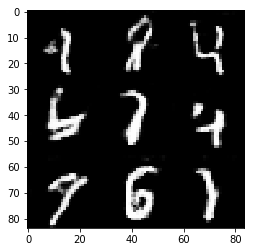

Epoch 2/2... Discriminator Loss: 0.7235... Generator Loss: 1.3244
Epoch 2/2... Discriminator Loss: 0.6930... Generator Loss: 1.4554
Epoch 2/2... Discriminator Loss: 0.7953... Generator Loss: 1.1514
Epoch 2/2... Discriminator Loss: 0.7131... Generator Loss: 1.3813
Epoch 2/2... Discriminator Loss: 1.0766... Generator Loss: 0.7587
Epoch 2/2... Discriminator Loss: 0.7793... Generator Loss: 1.5192
Epoch 2/2... Discriminator Loss: 1.5646... Generator Loss: 0.5737
Epoch 2/2... Discriminator Loss: 1.0930... Generator Loss: 1.8566
Epoch 2/2... Discriminator Loss: 0.9279... Generator Loss: 1.0191
Epoch 2/2... Discriminator Loss: 0.7027... Generator Loss: 1.2809
Epoch 2/2... Discriminator Loss: 1.0912... Generator Loss: 0.7443
Epoch 2/2... Discriminator Loss: 0.8845... Generator Loss: 0.9763
Epoch 2/2... Discriminator Loss: 0.9607... Generator Loss: 0.9421
Epoch 2/2... Discriminator Loss: 1.0203... Generator Loss: 0.8592
Epoch 2/2... Discriminator Loss: 0.7936... Generator Loss: 1.5830
Epoch 2/2.

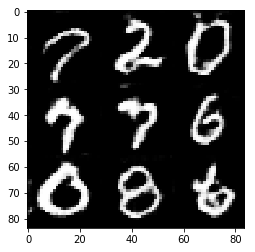

Epoch 2/2... Discriminator Loss: 0.7599... Generator Loss: 1.7319
Epoch 2/2... Discriminator Loss: 0.9483... Generator Loss: 0.9041
Epoch 2/2... Discriminator Loss: 1.3998... Generator Loss: 0.6429
Epoch 2/2... Discriminator Loss: 0.7100... Generator Loss: 1.4193
Epoch 2/2... Discriminator Loss: 0.7977... Generator Loss: 1.1074
Epoch 2/2... Discriminator Loss: 0.8525... Generator Loss: 1.0923
Epoch 2/2... Discriminator Loss: 0.9717... Generator Loss: 0.9208
Epoch 2/2... Discriminator Loss: 0.7942... Generator Loss: 1.2743
Epoch 2/2... Discriminator Loss: 1.2189... Generator Loss: 0.7122
Epoch 2/2... Discriminator Loss: 0.8660... Generator Loss: 1.7920
Epoch 2/2... Discriminator Loss: 1.1147... Generator Loss: 0.8703
Epoch 2/2... Discriminator Loss: 0.8017... Generator Loss: 1.6967
Epoch 2/2... Discriminator Loss: 0.7409... Generator Loss: 1.2503
Epoch 2/2... Discriminator Loss: 0.6964... Generator Loss: 1.3827
Epoch 2/2... Discriminator Loss: 1.1917... Generator Loss: 0.6615
Epoch 2/2.

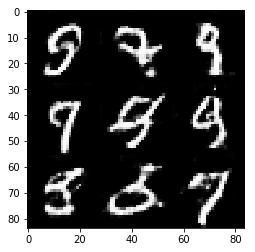

Epoch 2/2... Discriminator Loss: 0.8801... Generator Loss: 1.0998
Epoch 2/2... Discriminator Loss: 1.9817... Generator Loss: 0.4429
Epoch 2/2... Discriminator Loss: 1.0253... Generator Loss: 1.5674
Epoch 2/2... Discriminator Loss: 1.0425... Generator Loss: 0.9351
Epoch 2/2... Discriminator Loss: 1.0128... Generator Loss: 0.9256
Epoch 2/2... Discriminator Loss: 0.8410... Generator Loss: 1.1745
Epoch 2/2... Discriminator Loss: 1.1435... Generator Loss: 0.6885
Epoch 2/2... Discriminator Loss: 0.8463... Generator Loss: 1.0954
Epoch 2/2... Discriminator Loss: 0.7648... Generator Loss: 1.3468
Epoch 2/2... Discriminator Loss: 1.6318... Generator Loss: 0.4999
Epoch 2/2... Discriminator Loss: 1.1296... Generator Loss: 1.7195
Epoch 2/2... Discriminator Loss: 1.5222... Generator Loss: 0.5947
Epoch 2/2... Discriminator Loss: 0.8551... Generator Loss: 1.3330
Epoch 2/2... Discriminator Loss: 0.8874... Generator Loss: 1.0285
Epoch 2/2... Discriminator Loss: 0.7696... Generator Loss: 1.3605
Epoch 2/2.

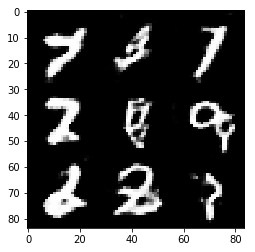

Epoch 2/2... Discriminator Loss: 0.8910... Generator Loss: 1.0014
Epoch 2/2... Discriminator Loss: 0.7324... Generator Loss: 1.5032
Epoch 2/2... Discriminator Loss: 1.1015... Generator Loss: 0.7266
Epoch 2/2... Discriminator Loss: 0.9006... Generator Loss: 1.0288
Epoch 2/2... Discriminator Loss: 0.7356... Generator Loss: 2.0938
Epoch 2/2... Discriminator Loss: 0.9493... Generator Loss: 0.9677
Epoch 2/2... Discriminator Loss: 0.9223... Generator Loss: 0.9209
Epoch 2/2... Discriminator Loss: 1.2886... Generator Loss: 0.6879
Epoch 2/2... Discriminator Loss: 0.7512... Generator Loss: 1.4614
Epoch 2/2... Discriminator Loss: 0.7896... Generator Loss: 1.2342
Epoch 2/2... Discriminator Loss: 0.8430... Generator Loss: 1.0019
Epoch 2/2... Discriminator Loss: 0.6349... Generator Loss: 2.2556
Epoch 2/2... Discriminator Loss: 1.0308... Generator Loss: 0.9164
Epoch 2/2... Discriminator Loss: 0.6720... Generator Loss: 1.4280
Epoch 2/2... Discriminator Loss: 0.8105... Generator Loss: 1.6692
Epoch 2/2.

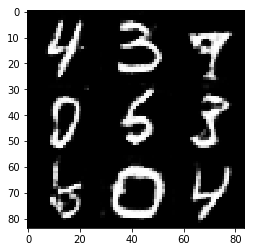

Epoch 2/2... Discriminator Loss: 1.0032... Generator Loss: 0.8834
Epoch 2/2... Discriminator Loss: 0.8233... Generator Loss: 1.3026
Epoch 2/2... Discriminator Loss: 0.9470... Generator Loss: 1.0006
Epoch 2/2... Discriminator Loss: 0.7028... Generator Loss: 1.2970
Epoch 2/2... Discriminator Loss: 0.7330... Generator Loss: 1.2906
Epoch 2/2... Discriminator Loss: 0.9621... Generator Loss: 0.9074
Epoch 2/2... Discriminator Loss: 1.0689... Generator Loss: 0.7552
Epoch 2/2... Discriminator Loss: 1.0508... Generator Loss: 1.1432
Epoch 2/2... Discriminator Loss: 0.8420... Generator Loss: 1.1020
Epoch 2/2... Discriminator Loss: 0.8734... Generator Loss: 0.9944
Epoch 2/2... Discriminator Loss: 0.8764... Generator Loss: 0.9793
Epoch 2/2... Discriminator Loss: 0.8539... Generator Loss: 1.4235
Epoch 2/2... Discriminator Loss: 1.1126... Generator Loss: 0.7669
Epoch 2/2... Discriminator Loss: 1.2157... Generator Loss: 0.8612
Epoch 2/2... Discriminator Loss: 0.9951... Generator Loss: 1.0935
Epoch 2/2.

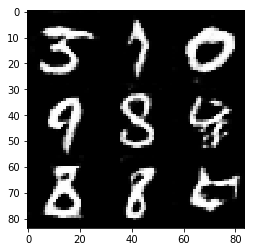

Epoch 2/2... Discriminator Loss: 0.6656... Generator Loss: 1.3669
Epoch 2/2... Discriminator Loss: 0.8001... Generator Loss: 1.1190
Epoch 2/2... Discriminator Loss: 0.6765... Generator Loss: 1.6892
Epoch 2/2... Discriminator Loss: 0.9756... Generator Loss: 0.8909
Epoch 2/2... Discriminator Loss: 0.7629... Generator Loss: 1.1681
Epoch 2/2... Discriminator Loss: 1.1255... Generator Loss: 0.7276
Epoch 2/2... Discriminator Loss: 0.7537... Generator Loss: 1.3461
Epoch 2/2... Discriminator Loss: 0.8974... Generator Loss: 0.9758
Epoch 2/2... Discriminator Loss: 0.7575... Generator Loss: 1.2713
Epoch 2/2... Discriminator Loss: 0.5445... Generator Loss: 1.9661
Epoch 2/2... Discriminator Loss: 1.2431... Generator Loss: 0.6856
Epoch 2/2... Discriminator Loss: 0.7284... Generator Loss: 1.7270
Epoch 2/2... Discriminator Loss: 0.9481... Generator Loss: 0.9318
Epoch 2/2... Discriminator Loss: 0.7645... Generator Loss: 1.2032
Epoch 2/2... Discriminator Loss: 0.5727... Generator Loss: 1.7684
Epoch 2/2.

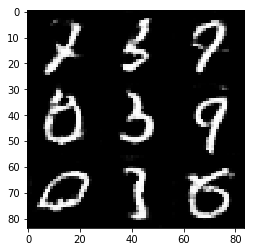

Epoch 2/2... Discriminator Loss: 1.4930... Generator Loss: 0.7296
Epoch 2/2... Discriminator Loss: 0.8960... Generator Loss: 1.9334
Epoch 2/2... Discriminator Loss: 1.3528... Generator Loss: 0.6672
Epoch 2/2... Discriminator Loss: 0.7356... Generator Loss: 1.6444
Epoch 2/2... Discriminator Loss: 0.8684... Generator Loss: 1.0753
Epoch 2/2... Discriminator Loss: 0.7752... Generator Loss: 1.1472
Epoch 2/2... Discriminator Loss: 0.6281... Generator Loss: 1.8747
Epoch 2/2... Discriminator Loss: 0.5714... Generator Loss: 1.7294
Epoch 2/2... Discriminator Loss: 0.8063... Generator Loss: 1.1495
Epoch 2/2... Discriminator Loss: 0.5715... Generator Loss: 1.7163
Epoch 2/2... Discriminator Loss: 0.6693... Generator Loss: 1.3633
Epoch 2/2... Discriminator Loss: 0.9385... Generator Loss: 0.9043
Epoch 2/2... Discriminator Loss: 0.7858... Generator Loss: 1.3481
Epoch 2/2... Discriminator Loss: 0.5802... Generator Loss: 1.6818
Epoch 2/2... Discriminator Loss: 1.2977... Generator Loss: 0.6597
Epoch 2/2.

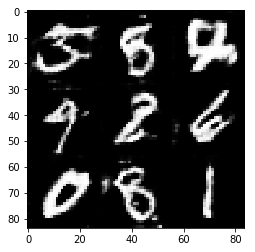

Epoch 2/2... Discriminator Loss: 0.8755... Generator Loss: 2.2418
Epoch 2/2... Discriminator Loss: 1.7711... Generator Loss: 0.4505
Epoch 2/2... Discriminator Loss: 0.7710... Generator Loss: 2.1784
Epoch 2/2... Discriminator Loss: 0.7182... Generator Loss: 1.3423
Epoch 2/2... Discriminator Loss: 1.0136... Generator Loss: 0.8586
Epoch 2/2... Discriminator Loss: 1.1303... Generator Loss: 0.7849
Epoch 2/2... Discriminator Loss: 0.8280... Generator Loss: 1.8281
Epoch 2/2... Discriminator Loss: 1.2658... Generator Loss: 0.8676
Epoch 2/2... Discriminator Loss: 0.6691... Generator Loss: 2.0165
Epoch 2/2... Discriminator Loss: 1.1988... Generator Loss: 0.8038
Epoch 2/2... Discriminator Loss: 0.7196... Generator Loss: 1.3556
Epoch 2/2... Discriminator Loss: 0.6807... Generator Loss: 1.8602
Epoch 2/2... Discriminator Loss: 0.6424... Generator Loss: 1.4414
Epoch 2/2... Discriminator Loss: 0.7457... Generator Loss: 1.2371
Epoch 2/2... Discriminator Loss: 0.6667... Generator Loss: 1.3254
Epoch 2/2.

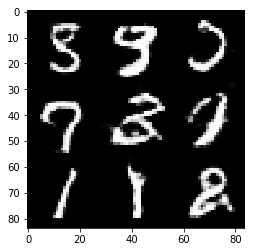

Epoch 2/2... Discriminator Loss: 1.2245... Generator Loss: 2.2647
Epoch 2/2... Discriminator Loss: 1.2377... Generator Loss: 0.7255
Epoch 2/2... Discriminator Loss: 0.8703... Generator Loss: 1.5480
Epoch 2/2... Discriminator Loss: 1.2346... Generator Loss: 0.7229
Epoch 2/2... Discriminator Loss: 1.0515... Generator Loss: 1.5878
Epoch 2/2... Discriminator Loss: 1.0246... Generator Loss: 0.9355
Epoch 2/2... Discriminator Loss: 1.0367... Generator Loss: 0.7836
Epoch 2/2... Discriminator Loss: 1.1973... Generator Loss: 2.0985
Epoch 2/2... Discriminator Loss: 1.1332... Generator Loss: 0.7958
Epoch 2/2... Discriminator Loss: 0.8999... Generator Loss: 1.2683
Epoch 2/2... Discriminator Loss: 0.9710... Generator Loss: 0.9524
Epoch 2/2... Discriminator Loss: 1.1477... Generator Loss: 0.7809
Epoch 2/2... Discriminator Loss: 0.8423... Generator Loss: 1.0935
Epoch 2/2... Discriminator Loss: 0.7999... Generator Loss: 1.5474
Epoch 2/2... Discriminator Loss: 0.9139... Generator Loss: 1.0289
Epoch 2/2.

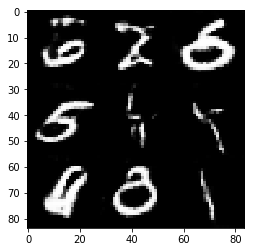

Epoch 2/2... Discriminator Loss: 0.7236... Generator Loss: 1.4016
Epoch 2/2... Discriminator Loss: 0.5033... Generator Loss: 2.2517
Epoch 2/2... Discriminator Loss: 2.1767... Generator Loss: 0.4148
Epoch 2/2... Discriminator Loss: 1.3012... Generator Loss: 4.2748
Epoch 2/2... Discriminator Loss: 1.9453... Generator Loss: 0.5382
Epoch 2/2... Discriminator Loss: 1.7628... Generator Loss: 3.0734
Epoch 2/2... Discriminator Loss: 1.4124... Generator Loss: 0.6683
Epoch 2/2... Discriminator Loss: 0.9379... Generator Loss: 1.1613
Epoch 2/2... Discriminator Loss: 0.7933... Generator Loss: 1.7370
Epoch 2/2... Discriminator Loss: 0.9624... Generator Loss: 0.9218
Epoch 2/2... Discriminator Loss: 1.0796... Generator Loss: 0.8822
Epoch 2/2... Discriminator Loss: 0.9205... Generator Loss: 1.3330
Epoch 2/2... Discriminator Loss: 0.7287... Generator Loss: 1.6043
Epoch 2/2... Discriminator Loss: 1.0261... Generator Loss: 0.8206
Epoch 2/2... Discriminator Loss: 0.8522... Generator Loss: 1.1902
Epoch 2/2.

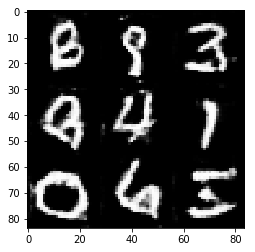

Epoch 2/2... Discriminator Loss: 0.8331... Generator Loss: 1.0801
Epoch 2/2... Discriminator Loss: 0.6001... Generator Loss: 1.6224
Epoch 2/2... Discriminator Loss: 0.5683... Generator Loss: 1.7897
Epoch 2/2... Discriminator Loss: 0.7032... Generator Loss: 1.2533
Epoch 2/2... Discriminator Loss: 1.1850... Generator Loss: 0.7122
Epoch 2/2... Discriminator Loss: 0.7094... Generator Loss: 1.5339
Epoch 2/2... Discriminator Loss: 0.9035... Generator Loss: 1.0028
Epoch 2/2... Discriminator Loss: 0.7880... Generator Loss: 1.2888
Epoch 2/2... Discriminator Loss: 0.8767... Generator Loss: 0.9814
Epoch 2/2... Discriminator Loss: 0.8512... Generator Loss: 1.0789
Epoch 2/2... Discriminator Loss: 0.8656... Generator Loss: 2.3315
Epoch 2/2... Discriminator Loss: 1.6053... Generator Loss: 0.5299
Epoch 2/2... Discriminator Loss: 0.7302... Generator Loss: 2.1178
Epoch 2/2... Discriminator Loss: 0.7408... Generator Loss: 1.2997
Epoch 2/2... Discriminator Loss: 0.7822... Generator Loss: 1.2729
Epoch 2/2.

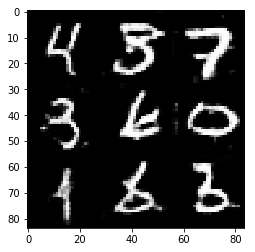

Epoch 2/2... Discriminator Loss: 1.1077... Generator Loss: 0.8307
Epoch 2/2... Discriminator Loss: 0.9856... Generator Loss: 1.7745
Epoch 2/2... Discriminator Loss: 1.5303... Generator Loss: 0.5506
Epoch 2/2... Discriminator Loss: 1.2677... Generator Loss: 2.1094
Epoch 2/2... Discriminator Loss: 1.1681... Generator Loss: 0.7121
Epoch 2/2... Discriminator Loss: 0.8309... Generator Loss: 1.0527
Epoch 2/2... Discriminator Loss: 0.7066... Generator Loss: 1.6301
Epoch 2/2... Discriminator Loss: 0.9748... Generator Loss: 0.9197
Epoch 2/2... Discriminator Loss: 0.7983... Generator Loss: 1.2294
Epoch 2/2... Discriminator Loss: 0.8744... Generator Loss: 1.1674
Epoch 2/2... Discriminator Loss: 1.2140... Generator Loss: 0.7215
Epoch 2/2... Discriminator Loss: 0.8628... Generator Loss: 1.0498
Epoch 2/2... Discriminator Loss: 0.9546... Generator Loss: 1.4371
Epoch 2/2... Discriminator Loss: 1.6037... Generator Loss: 0.6232
Epoch 2/2... Discriminator Loss: 0.8759... Generator Loss: 1.0313
Epoch 2/2.

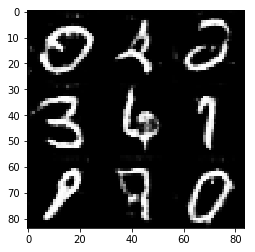

Epoch 2/2... Discriminator Loss: 0.6758... Generator Loss: 1.5443
Epoch 2/2... Discriminator Loss: 0.5605... Generator Loss: 1.6101
Epoch 2/2... Discriminator Loss: 0.7349... Generator Loss: 1.1927
Epoch 2/2... Discriminator Loss: 0.6106... Generator Loss: 1.5367
Epoch 2/2... Discriminator Loss: 0.9183... Generator Loss: 0.9011
Epoch 2/2... Discriminator Loss: 1.0324... Generator Loss: 0.8413
Epoch 2/2... Discriminator Loss: 0.7350... Generator Loss: 1.1712
Epoch 2/2... Discriminator Loss: 0.6519... Generator Loss: 1.3974
Epoch 2/2... Discriminator Loss: 0.8300... Generator Loss: 1.0190
Epoch 2/2... Discriminator Loss: 0.6632... Generator Loss: 1.3702
Epoch 2/2... Discriminator Loss: 0.5820... Generator Loss: 1.7160
Epoch 2/2... Discriminator Loss: 0.6556... Generator Loss: 1.3993
Epoch 2/2... Discriminator Loss: 0.5433... Generator Loss: 1.8785
Epoch 2/2... Discriminator Loss: 0.4713... Generator Loss: 2.0822
Epoch 2/2... Discriminator Loss: 0.9811... Generator Loss: 0.9564
Epoch 2/2.

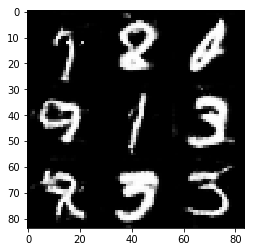

Epoch 2/2... Discriminator Loss: 0.9199... Generator Loss: 1.1088
Epoch 2/2... Discriminator Loss: 0.6485... Generator Loss: 1.5048
Epoch 2/2... Discriminator Loss: 0.6154... Generator Loss: 1.5643
Epoch 2/2... Discriminator Loss: 1.4698... Generator Loss: 0.5846
Epoch 2/2... Discriminator Loss: 0.7559... Generator Loss: 1.6652
Epoch 2/2... Discriminator Loss: 0.9883... Generator Loss: 0.9255
Epoch 2/2... Discriminator Loss: 1.3261... Generator Loss: 0.6036
Epoch 2/2... Discriminator Loss: 0.8475... Generator Loss: 1.0636
Epoch 2/2... Discriminator Loss: 0.8218... Generator Loss: 1.1448
Epoch 2/2... Discriminator Loss: 0.7417... Generator Loss: 1.2082
Epoch 2/2... Discriminator Loss: 0.8274... Generator Loss: 1.0600
Epoch 2/2... Discriminator Loss: 0.6278... Generator Loss: 1.6189
Epoch 2/2... Discriminator Loss: 0.9245... Generator Loss: 0.9813
Epoch 2/2... Discriminator Loss: 0.5590... Generator Loss: 1.7430
Epoch 2/2... Discriminator Loss: 0.6088... Generator Loss: 1.7534
Epoch 2/2.

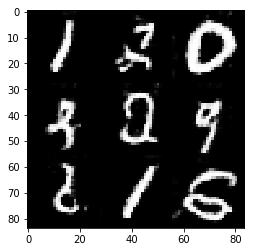

Epoch 2/2... Discriminator Loss: 0.8505... Generator Loss: 1.1342
Epoch 2/2... Discriminator Loss: 0.6034... Generator Loss: 1.9387
Epoch 2/2... Discriminator Loss: 0.9961... Generator Loss: 0.9124
Epoch 2/2... Discriminator Loss: 0.6675... Generator Loss: 1.4852
Epoch 2/2... Discriminator Loss: 0.5930... Generator Loss: 1.7103
Epoch 2/2... Discriminator Loss: 0.8374... Generator Loss: 1.1000
Epoch 2/2... Discriminator Loss: 0.5863... Generator Loss: 1.7626
Epoch 2/2... Discriminator Loss: 0.9373... Generator Loss: 1.0118
Epoch 2/2... Discriminator Loss: 0.6514... Generator Loss: 1.4702
Epoch 2/2... Discriminator Loss: 0.7197... Generator Loss: 1.1921
Epoch 2/2... Discriminator Loss: 1.0699... Generator Loss: 0.8563
Epoch 2/2... Discriminator Loss: 0.7863... Generator Loss: 2.4533
Epoch 2/2... Discriminator Loss: 0.5640... Generator Loss: 1.6839
Epoch 2/2... Discriminator Loss: 0.6618... Generator Loss: 1.3715
Epoch 2/2... Discriminator Loss: 0.6543... Generator Loss: 1.5898
Epoch 2/2.

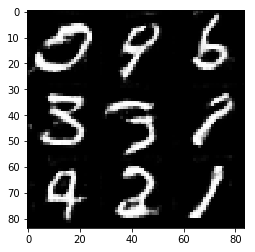

Epoch 2/2... Discriminator Loss: 1.1237... Generator Loss: 0.8158
Epoch 2/2... Discriminator Loss: 0.9678... Generator Loss: 1.2377
Epoch 2/2... Discriminator Loss: 1.0662... Generator Loss: 0.8939
Epoch 2/2... Discriminator Loss: 0.7910... Generator Loss: 1.4879
Epoch 2/2... Discriminator Loss: 0.9416... Generator Loss: 0.9601
Epoch 2/2... Discriminator Loss: 0.9549... Generator Loss: 0.9928
Epoch 2/2... Discriminator Loss: 1.5305... Generator Loss: 0.5881
Epoch 2/2... Discriminator Loss: 0.6931... Generator Loss: 1.9826
Epoch 2/2... Discriminator Loss: 0.5026... Generator Loss: 2.0160
Epoch 2/2... Discriminator Loss: 1.3204... Generator Loss: 0.7368
Epoch 2/2... Discriminator Loss: 0.5391... Generator Loss: 2.0405
Epoch 2/2... Discriminator Loss: 0.5086... Generator Loss: 2.5188
Epoch 2/2... Discriminator Loss: 1.1631... Generator Loss: 0.8225
Epoch 2/2... Discriminator Loss: 0.9902... Generator Loss: 1.5077
Epoch 2/2... Discriminator Loss: 1.2355... Generator Loss: 0.6807
Epoch 2/2.

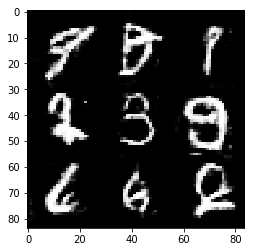

Epoch 2/2... Discriminator Loss: 0.7895... Generator Loss: 1.1219
Epoch 2/2... Discriminator Loss: 0.6297... Generator Loss: 1.5987
Epoch 2/2... Discriminator Loss: 0.7143... Generator Loss: 1.3017
Epoch 2/2... Discriminator Loss: 1.0594... Generator Loss: 0.8078
Epoch 2/2... Discriminator Loss: 0.8950... Generator Loss: 1.4532
Epoch 2/2... Discriminator Loss: 1.2265... Generator Loss: 0.6553
Epoch 2/2... Discriminator Loss: 0.7328... Generator Loss: 1.3849
Epoch 2/2... Discriminator Loss: 0.6035... Generator Loss: 1.8962
Epoch 2/2... Discriminator Loss: 0.6433... Generator Loss: 1.4545
Epoch 2/2... Discriminator Loss: 1.3171... Generator Loss: 0.6162
Epoch 2/2... Discriminator Loss: 0.7150... Generator Loss: 2.3077
Epoch 2/2... Discriminator Loss: 0.7885... Generator Loss: 1.2060
Epoch 2/2... Discriminator Loss: 1.0039... Generator Loss: 0.8956
Epoch 2/2... Discriminator Loss: 0.7288... Generator Loss: 1.4124
Epoch 2/2... Discriminator Loss: 0.8790... Generator Loss: 1.0510
Epoch 2/2.

In [32]:
batch_size = 32
z_dim = 100
learning_rate = 0.0005
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
在 CelebA 上运行你的 GANs 模型。在一般的GPU上运行每次迭代大约需要 20 分钟。你可以运行整个迭代，或者当 GANs 开始产生真实人脸图像时停止它。

Epoch 1/1... Discriminator Loss: 5.9510... Generator Loss: 0.5274
Epoch 1/1... Discriminator Loss: 1.9800... Generator Loss: 0.7174
Epoch 1/1... Discriminator Loss: 4.0159... Generator Loss: 0.4189
Epoch 1/1... Discriminator Loss: 1.0104... Generator Loss: 3.7820
Epoch 1/1... Discriminator Loss: 2.2847... Generator Loss: 0.4617
Epoch 1/1... Discriminator Loss: 1.3628... Generator Loss: 0.8235
Epoch 1/1... Discriminator Loss: 2.1228... Generator Loss: 0.5248
Epoch 1/1... Discriminator Loss: 0.6347... Generator Loss: 4.8668
Epoch 1/1... Discriminator Loss: 1.7500... Generator Loss: 0.7850
Epoch 1/1... Discriminator Loss: 0.7850... Generator Loss: 8.0197
Epoch 1/1... Discriminator Loss: 0.5884... Generator Loss: 2.9876
Epoch 1/1... Discriminator Loss: 3.1513... Generator Loss: 0.3729
Epoch 1/1... Discriminator Loss: 3.0150... Generator Loss: 11.5788
Epoch 1/1... Discriminator Loss: 1.7629... Generator Loss: 1.3107
Epoch 1/1... Discriminator Loss: 3.8563... Generator Loss: 0.4422
Epoch 1/1

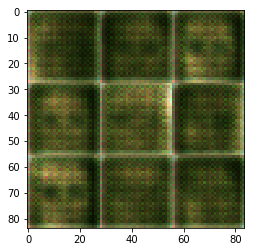

Epoch 1/1... Discriminator Loss: 1.3491... Generator Loss: 0.6942
Epoch 1/1... Discriminator Loss: 1.4297... Generator Loss: 4.4998
Epoch 1/1... Discriminator Loss: 2.5521... Generator Loss: 0.3447
Epoch 1/1... Discriminator Loss: 3.0518... Generator Loss: 5.7838
Epoch 1/1... Discriminator Loss: 1.9297... Generator Loss: 0.4097
Epoch 1/1... Discriminator Loss: 1.0880... Generator Loss: 1.4393
Epoch 1/1... Discriminator Loss: 0.8586... Generator Loss: 1.2565
Epoch 1/1... Discriminator Loss: 1.2441... Generator Loss: 0.6969
Epoch 1/1... Discriminator Loss: 1.7429... Generator Loss: 1.2312
Epoch 1/1... Discriminator Loss: 1.2487... Generator Loss: 0.9838
Epoch 1/1... Discriminator Loss: 0.7772... Generator Loss: 1.5741
Epoch 1/1... Discriminator Loss: 1.4686... Generator Loss: 0.6100
Epoch 1/1... Discriminator Loss: 1.4346... Generator Loss: 2.6903
Epoch 1/1... Discriminator Loss: 2.1225... Generator Loss: 0.4165
Epoch 1/1... Discriminator Loss: 1.1509... Generator Loss: 1.0654
Epoch 1/1.

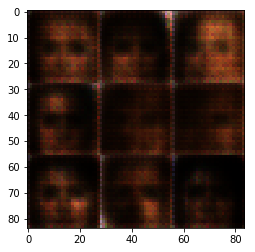

Epoch 1/1... Discriminator Loss: 0.7944... Generator Loss: 1.2066
Epoch 1/1... Discriminator Loss: 1.0720... Generator Loss: 0.8811
Epoch 1/1... Discriminator Loss: 0.7546... Generator Loss: 2.0414
Epoch 1/1... Discriminator Loss: 2.9259... Generator Loss: 0.3435
Epoch 1/1... Discriminator Loss: 1.9785... Generator Loss: 3.3541
Epoch 1/1... Discriminator Loss: 1.0942... Generator Loss: 1.4045
Epoch 1/1... Discriminator Loss: 1.5602... Generator Loss: 0.4785
Epoch 1/1... Discriminator Loss: 1.0251... Generator Loss: 1.0797
Epoch 1/1... Discriminator Loss: 0.8630... Generator Loss: 1.4865
Epoch 1/1... Discriminator Loss: 0.6166... Generator Loss: 1.8403
Epoch 1/1... Discriminator Loss: 1.3085... Generator Loss: 0.5830
Epoch 1/1... Discriminator Loss: 1.1445... Generator Loss: 1.9030
Epoch 1/1... Discriminator Loss: 1.4569... Generator Loss: 0.5948
Epoch 1/1... Discriminator Loss: 1.1489... Generator Loss: 0.7770
Epoch 1/1... Discriminator Loss: 1.1337... Generator Loss: 1.7198
Epoch 1/1.

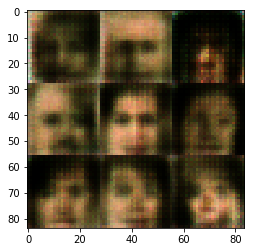

Epoch 1/1... Discriminator Loss: 0.9642... Generator Loss: 1.4341
Epoch 1/1... Discriminator Loss: 1.1369... Generator Loss: 0.7502
Epoch 1/1... Discriminator Loss: 1.1146... Generator Loss: 1.0726
Epoch 1/1... Discriminator Loss: 1.3727... Generator Loss: 0.5753
Epoch 1/1... Discriminator Loss: 0.9172... Generator Loss: 1.7933
Epoch 1/1... Discriminator Loss: 0.7619... Generator Loss: 1.1321
Epoch 1/1... Discriminator Loss: 0.5613... Generator Loss: 1.7563
Epoch 1/1... Discriminator Loss: 1.1702... Generator Loss: 0.6665
Epoch 1/1... Discriminator Loss: 1.8116... Generator Loss: 3.8879
Epoch 1/1... Discriminator Loss: 1.0692... Generator Loss: 0.8090
Epoch 1/1... Discriminator Loss: 0.8046... Generator Loss: 1.2582
Epoch 1/1... Discriminator Loss: 1.1873... Generator Loss: 0.6972
Epoch 1/1... Discriminator Loss: 1.0786... Generator Loss: 1.3688
Epoch 1/1... Discriminator Loss: 0.7936... Generator Loss: 1.1023
Epoch 1/1... Discriminator Loss: 1.0863... Generator Loss: 0.8642
Epoch 1/1.

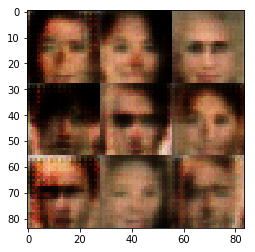

Epoch 1/1... Discriminator Loss: 2.6070... Generator Loss: 2.8025
Epoch 1/1... Discriminator Loss: 1.4025... Generator Loss: 0.9346
Epoch 1/1... Discriminator Loss: 1.8484... Generator Loss: 0.4104
Epoch 1/1... Discriminator Loss: 1.0450... Generator Loss: 1.5410
Epoch 1/1... Discriminator Loss: 0.9460... Generator Loss: 1.2511
Epoch 1/1... Discriminator Loss: 1.5833... Generator Loss: 0.4951
Epoch 1/1... Discriminator Loss: 0.9571... Generator Loss: 1.9983
Epoch 1/1... Discriminator Loss: 1.1976... Generator Loss: 0.6837
Epoch 1/1... Discriminator Loss: 0.5990... Generator Loss: 1.7954
Epoch 1/1... Discriminator Loss: 1.0810... Generator Loss: 0.8227
Epoch 1/1... Discriminator Loss: 1.0437... Generator Loss: 0.8013
Epoch 1/1... Discriminator Loss: 1.0002... Generator Loss: 1.1451
Epoch 1/1... Discriminator Loss: 0.9358... Generator Loss: 1.1056
Epoch 1/1... Discriminator Loss: 0.5442... Generator Loss: 1.6568
Epoch 1/1... Discriminator Loss: 2.3129... Generator Loss: 0.3605
Epoch 1/1.

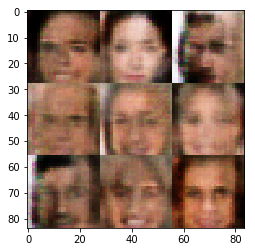

Epoch 1/1... Discriminator Loss: 1.2700... Generator Loss: 1.7472
Epoch 1/1... Discriminator Loss: 1.0565... Generator Loss: 0.8255
Epoch 1/1... Discriminator Loss: 1.0169... Generator Loss: 0.8800
Epoch 1/1... Discriminator Loss: 0.7792... Generator Loss: 1.2609
Epoch 1/1... Discriminator Loss: 0.8195... Generator Loss: 1.1188
Epoch 1/1... Discriminator Loss: 0.7147... Generator Loss: 1.4107
Epoch 1/1... Discriminator Loss: 0.5510... Generator Loss: 2.1010
Epoch 1/1... Discriminator Loss: 2.1975... Generator Loss: 0.3663
Epoch 1/1... Discriminator Loss: 1.5597... Generator Loss: 2.7916
Epoch 1/1... Discriminator Loss: 0.9646... Generator Loss: 0.9742
Epoch 1/1... Discriminator Loss: 1.4379... Generator Loss: 0.5125
Epoch 1/1... Discriminator Loss: 0.8418... Generator Loss: 1.9146
Epoch 1/1... Discriminator Loss: 1.0244... Generator Loss: 0.9690
Epoch 1/1... Discriminator Loss: 1.1580... Generator Loss: 0.6646
Epoch 1/1... Discriminator Loss: 0.9399... Generator Loss: 1.3705
Epoch 1/1.

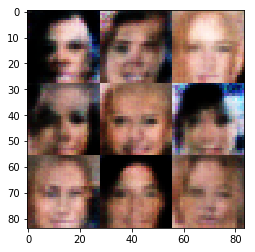

Epoch 1/1... Discriminator Loss: 0.9578... Generator Loss: 0.9874
Epoch 1/1... Discriminator Loss: 0.6750... Generator Loss: 1.5255
Epoch 1/1... Discriminator Loss: 0.9068... Generator Loss: 0.8558
Epoch 1/1... Discriminator Loss: 0.9236... Generator Loss: 1.2167
Epoch 1/1... Discriminator Loss: 0.4948... Generator Loss: 2.0568
Epoch 1/1... Discriminator Loss: 0.9133... Generator Loss: 0.9481
Epoch 1/1... Discriminator Loss: 0.7299... Generator Loss: 2.2287
Epoch 1/1... Discriminator Loss: 1.4097... Generator Loss: 0.5415
Epoch 1/1... Discriminator Loss: 2.1443... Generator Loss: 2.1082
Epoch 1/1... Discriminator Loss: 1.1259... Generator Loss: 0.7002
Epoch 1/1... Discriminator Loss: 0.9500... Generator Loss: 1.2510
Epoch 1/1... Discriminator Loss: 0.9417... Generator Loss: 0.9073
Epoch 1/1... Discriminator Loss: 0.8372... Generator Loss: 1.0447
Epoch 1/1... Discriminator Loss: 1.1784... Generator Loss: 1.9878
Epoch 1/1... Discriminator Loss: 1.6512... Generator Loss: 0.4566
Epoch 1/1.

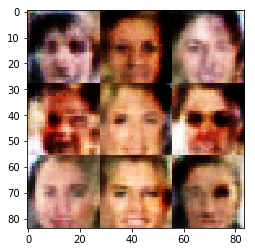

Epoch 1/1... Discriminator Loss: 0.4964... Generator Loss: 2.4544
Epoch 1/1... Discriminator Loss: 0.5410... Generator Loss: 2.0270
Epoch 1/1... Discriminator Loss: 0.4491... Generator Loss: 2.1660
Epoch 1/1... Discriminator Loss: 0.5868... Generator Loss: 1.5230
Epoch 1/1... Discriminator Loss: 0.5823... Generator Loss: 1.8351
Epoch 1/1... Discriminator Loss: 0.4122... Generator Loss: 3.1886
Epoch 1/1... Discriminator Loss: 0.4114... Generator Loss: 2.4956
Epoch 1/1... Discriminator Loss: 1.8622... Generator Loss: 0.3980
Epoch 1/1... Discriminator Loss: 1.8195... Generator Loss: 2.3599
Epoch 1/1... Discriminator Loss: 0.7670... Generator Loss: 1.0894
Epoch 1/1... Discriminator Loss: 0.5926... Generator Loss: 1.8867
Epoch 1/1... Discriminator Loss: 1.2209... Generator Loss: 0.6474
Epoch 1/1... Discriminator Loss: 1.9211... Generator Loss: 2.6583
Epoch 1/1... Discriminator Loss: 0.7862... Generator Loss: 1.3339
Epoch 1/1... Discriminator Loss: 0.9433... Generator Loss: 0.8384
Epoch 1/1.

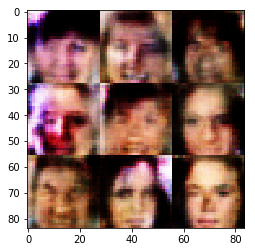

Epoch 1/1... Discriminator Loss: 0.4120... Generator Loss: 3.6679
Epoch 1/1... Discriminator Loss: 0.3706... Generator Loss: 3.3183
Epoch 1/1... Discriminator Loss: 0.7551... Generator Loss: 1.1003
Epoch 1/1... Discriminator Loss: 0.7876... Generator Loss: 1.6149
Epoch 1/1... Discriminator Loss: 0.6270... Generator Loss: 2.4747
Epoch 1/1... Discriminator Loss: 0.8516... Generator Loss: 0.9582
Epoch 1/1... Discriminator Loss: 1.0776... Generator Loss: 3.1994
Epoch 1/1... Discriminator Loss: 0.8868... Generator Loss: 0.8869
Epoch 1/1... Discriminator Loss: 0.8409... Generator Loss: 2.5472
Epoch 1/1... Discriminator Loss: 1.1264... Generator Loss: 0.7034
Epoch 1/1... Discriminator Loss: 2.1929... Generator Loss: 3.0744
Epoch 1/1... Discriminator Loss: 1.2643... Generator Loss: 0.6837
Epoch 1/1... Discriminator Loss: 0.8897... Generator Loss: 2.6189
Epoch 1/1... Discriminator Loss: 0.6291... Generator Loss: 1.7029
Epoch 1/1... Discriminator Loss: 0.6134... Generator Loss: 1.7834
Epoch 1/1.

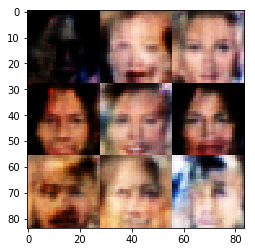

Epoch 1/1... Discriminator Loss: 0.7453... Generator Loss: 1.0794
Epoch 1/1... Discriminator Loss: 1.0172... Generator Loss: 2.7989
Epoch 1/1... Discriminator Loss: 0.7980... Generator Loss: 1.0286
Epoch 1/1... Discriminator Loss: 0.6379... Generator Loss: 2.4204
Epoch 1/1... Discriminator Loss: 0.7842... Generator Loss: 1.0762
Epoch 1/1... Discriminator Loss: 1.0823... Generator Loss: 2.2001
Epoch 1/1... Discriminator Loss: 1.0233... Generator Loss: 0.7570
Epoch 1/1... Discriminator Loss: 1.5706... Generator Loss: 2.7723
Epoch 1/1... Discriminator Loss: 1.7702... Generator Loss: 0.4503
Epoch 1/1... Discriminator Loss: 1.8557... Generator Loss: 2.4503
Epoch 1/1... Discriminator Loss: 1.6216... Generator Loss: 0.4687
Epoch 1/1... Discriminator Loss: 1.3556... Generator Loss: 1.4821
Epoch 1/1... Discriminator Loss: 1.7600... Generator Loss: 0.4703
Epoch 1/1... Discriminator Loss: 1.2685... Generator Loss: 0.7540
Epoch 1/1... Discriminator Loss: 1.4092... Generator Loss: 1.7812
Epoch 1/1.

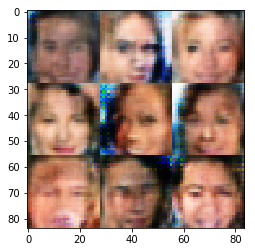

Epoch 1/1... Discriminator Loss: 0.6200... Generator Loss: 2.2862
Epoch 1/1... Discriminator Loss: 1.1871... Generator Loss: 0.6917
Epoch 1/1... Discriminator Loss: 0.7039... Generator Loss: 1.9308
Epoch 1/1... Discriminator Loss: 0.8586... Generator Loss: 0.9898
Epoch 1/1... Discriminator Loss: 0.9365... Generator Loss: 0.9458
Epoch 1/1... Discriminator Loss: 1.0068... Generator Loss: 1.2397
Epoch 1/1... Discriminator Loss: 1.3498... Generator Loss: 0.5454
Epoch 1/1... Discriminator Loss: 2.5660... Generator Loss: 3.0247
Epoch 1/1... Discriminator Loss: 0.9440... Generator Loss: 1.0061
Epoch 1/1... Discriminator Loss: 1.0179... Generator Loss: 0.8019
Epoch 1/1... Discriminator Loss: 0.9917... Generator Loss: 1.0158
Epoch 1/1... Discriminator Loss: 0.9632... Generator Loss: 0.9447
Epoch 1/1... Discriminator Loss: 0.9389... Generator Loss: 0.9400
Epoch 1/1... Discriminator Loss: 1.0184... Generator Loss: 1.0041
Epoch 1/1... Discriminator Loss: 0.8596... Generator Loss: 1.5983
Epoch 1/1.

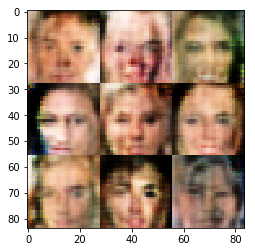

Epoch 1/1... Discriminator Loss: 0.4541... Generator Loss: 2.2611
Epoch 1/1... Discriminator Loss: 1.2914... Generator Loss: 0.5950
Epoch 1/1... Discriminator Loss: 1.3547... Generator Loss: 1.8232
Epoch 1/1... Discriminator Loss: 1.0241... Generator Loss: 0.8095
Epoch 1/1... Discriminator Loss: 0.7323... Generator Loss: 2.6419
Epoch 1/1... Discriminator Loss: 1.4109... Generator Loss: 0.5198
Epoch 1/1... Discriminator Loss: 0.8255... Generator Loss: 1.3765
Epoch 1/1... Discriminator Loss: 0.8242... Generator Loss: 1.2189
Epoch 1/1... Discriminator Loss: 0.6898... Generator Loss: 1.4304
Epoch 1/1... Discriminator Loss: 0.6311... Generator Loss: 3.3807
Epoch 1/1... Discriminator Loss: 0.6475... Generator Loss: 1.3099
Epoch 1/1... Discriminator Loss: 0.5671... Generator Loss: 1.9435
Epoch 1/1... Discriminator Loss: 0.5903... Generator Loss: 1.4972
Epoch 1/1... Discriminator Loss: 0.7936... Generator Loss: 1.1205
Epoch 1/1... Discriminator Loss: 0.7910... Generator Loss: 1.0495
Epoch 1/1.

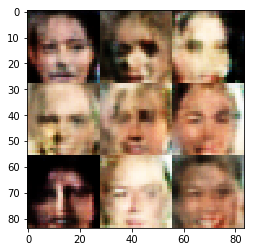

Epoch 1/1... Discriminator Loss: 2.3056... Generator Loss: 3.2471
Epoch 1/1... Discriminator Loss: 1.6595... Generator Loss: 0.4501
Epoch 1/1... Discriminator Loss: 1.8629... Generator Loss: 2.1906
Epoch 1/1... Discriminator Loss: 1.0903... Generator Loss: 0.8585
Epoch 1/1... Discriminator Loss: 1.1311... Generator Loss: 0.7261
Epoch 1/1... Discriminator Loss: 0.9318... Generator Loss: 1.3460
Epoch 1/1... Discriminator Loss: 0.9585... Generator Loss: 0.9317
Epoch 1/1... Discriminator Loss: 0.8714... Generator Loss: 1.0790
Epoch 1/1... Discriminator Loss: 0.6773... Generator Loss: 2.3146
Epoch 1/1... Discriminator Loss: 1.4482... Generator Loss: 0.5061
Epoch 1/1... Discriminator Loss: 0.8931... Generator Loss: 1.7087
Epoch 1/1... Discriminator Loss: 0.7195... Generator Loss: 1.4404
Epoch 1/1... Discriminator Loss: 0.6022... Generator Loss: 1.8198
Epoch 1/1... Discriminator Loss: 0.7481... Generator Loss: 1.1353
Epoch 1/1... Discriminator Loss: 0.5677... Generator Loss: 1.8192
Epoch 1/1.

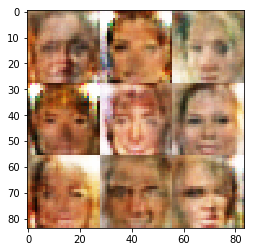

Epoch 1/1... Discriminator Loss: 0.7017... Generator Loss: 1.3557
Epoch 1/1... Discriminator Loss: 0.3883... Generator Loss: 3.2919
Epoch 1/1... Discriminator Loss: 0.4579... Generator Loss: 2.0846
Epoch 1/1... Discriminator Loss: 1.4219... Generator Loss: 0.5373
Epoch 1/1... Discriminator Loss: 1.1366... Generator Loss: 4.0609
Epoch 1/1... Discriminator Loss: 0.4884... Generator Loss: 2.4582
Epoch 1/1... Discriminator Loss: 0.6201... Generator Loss: 1.6144
Epoch 1/1... Discriminator Loss: 0.4218... Generator Loss: 2.8189
Epoch 1/1... Discriminator Loss: 0.9986... Generator Loss: 0.9597
Epoch 1/1... Discriminator Loss: 0.5166... Generator Loss: 2.0839
Epoch 1/1... Discriminator Loss: 0.6585... Generator Loss: 1.4938
Epoch 1/1... Discriminator Loss: 0.4417... Generator Loss: 2.6336
Epoch 1/1... Discriminator Loss: 0.5115... Generator Loss: 1.8984
Epoch 1/1... Discriminator Loss: 0.4487... Generator Loss: 3.0774
Epoch 1/1... Discriminator Loss: 0.8121... Generator Loss: 1.1224
Epoch 1/1.

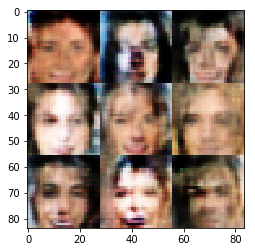

Epoch 1/1... Discriminator Loss: 1.1158... Generator Loss: 1.3288
Epoch 1/1... Discriminator Loss: 1.4397... Generator Loss: 0.5295
Epoch 1/1... Discriminator Loss: 1.1856... Generator Loss: 1.2609
Epoch 1/1... Discriminator Loss: 1.4358... Generator Loss: 0.5615
Epoch 1/1... Discriminator Loss: 1.0117... Generator Loss: 1.1188
Epoch 1/1... Discriminator Loss: 0.8624... Generator Loss: 1.1306
Epoch 1/1... Discriminator Loss: 0.9882... Generator Loss: 0.9125
Epoch 1/1... Discriminator Loss: 1.2013... Generator Loss: 0.6370
Epoch 1/1... Discriminator Loss: 1.0497... Generator Loss: 1.4641
Epoch 1/1... Discriminator Loss: 1.3849... Generator Loss: 0.5589
Epoch 1/1... Discriminator Loss: 1.0356... Generator Loss: 1.6426
Epoch 1/1... Discriminator Loss: 0.6398... Generator Loss: 1.7035
Epoch 1/1... Discriminator Loss: 0.8684... Generator Loss: 0.9790
Epoch 1/1... Discriminator Loss: 0.9825... Generator Loss: 0.9340
Epoch 1/1... Discriminator Loss: 0.9978... Generator Loss: 0.8287
Epoch 1/1.

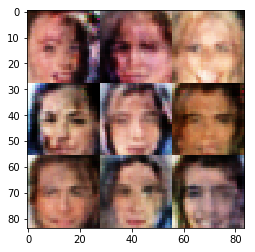

Epoch 1/1... Discriminator Loss: 1.0407... Generator Loss: 0.9141
Epoch 1/1... Discriminator Loss: 1.3681... Generator Loss: 0.6648
Epoch 1/1... Discriminator Loss: 1.2253... Generator Loss: 0.8638
Epoch 1/1... Discriminator Loss: 1.3387... Generator Loss: 0.5963
Epoch 1/1... Discriminator Loss: 0.9481... Generator Loss: 1.2399
Epoch 1/1... Discriminator Loss: 0.7398... Generator Loss: 1.4123
Epoch 1/1... Discriminator Loss: 1.9648... Generator Loss: 0.3906
Epoch 1/1... Discriminator Loss: 1.4370... Generator Loss: 1.7879
Epoch 1/1... Discriminator Loss: 1.2969... Generator Loss: 0.6722
Epoch 1/1... Discriminator Loss: 1.3602... Generator Loss: 0.6400
Epoch 1/1... Discriminator Loss: 1.0294... Generator Loss: 0.9617
Epoch 1/1... Discriminator Loss: 1.1045... Generator Loss: 0.8432
Epoch 1/1... Discriminator Loss: 1.2175... Generator Loss: 0.7407
Epoch 1/1... Discriminator Loss: 1.0469... Generator Loss: 0.9271
Epoch 1/1... Discriminator Loss: 1.0674... Generator Loss: 0.8932
Epoch 1/1.

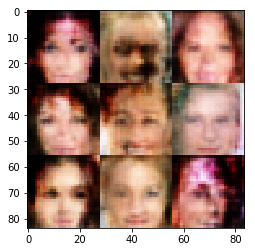

Epoch 1/1... Discriminator Loss: 1.1936... Generator Loss: 0.6946
Epoch 1/1... Discriminator Loss: 0.8207... Generator Loss: 1.7889
Epoch 1/1... Discriminator Loss: 0.9458... Generator Loss: 0.8552
Epoch 1/1... Discriminator Loss: 1.2847... Generator Loss: 0.6306
Epoch 1/1... Discriminator Loss: 1.2275... Generator Loss: 1.2212
Epoch 1/1... Discriminator Loss: 0.8320... Generator Loss: 1.1608
Epoch 1/1... Discriminator Loss: 0.5812... Generator Loss: 1.6839
Epoch 1/1... Discriminator Loss: 1.0141... Generator Loss: 0.8379
Epoch 1/1... Discriminator Loss: 1.1594... Generator Loss: 1.4802
Epoch 1/1... Discriminator Loss: 0.8450... Generator Loss: 0.9801
Epoch 1/1... Discriminator Loss: 0.6713... Generator Loss: 1.7328
Epoch 1/1... Discriminator Loss: 0.9776... Generator Loss: 0.8309
Epoch 1/1... Discriminator Loss: 0.6684... Generator Loss: 1.8220
Epoch 1/1... Discriminator Loss: 0.9017... Generator Loss: 0.8886
Epoch 1/1... Discriminator Loss: 0.9723... Generator Loss: 2.2327
Epoch 1/1.

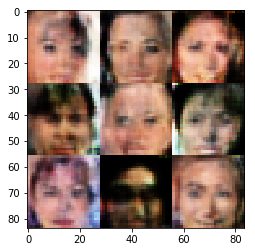

Epoch 1/1... Discriminator Loss: 1.1520... Generator Loss: 0.7196
Epoch 1/1... Discriminator Loss: 1.1631... Generator Loss: 1.5324
Epoch 1/1... Discriminator Loss: 1.9459... Generator Loss: 0.3934
Epoch 1/1... Discriminator Loss: 1.9547... Generator Loss: 2.7533
Epoch 1/1... Discriminator Loss: 1.2891... Generator Loss: 0.6591
Epoch 1/1... Discriminator Loss: 1.3055... Generator Loss: 1.2955
Epoch 1/1... Discriminator Loss: 1.2641... Generator Loss: 0.6772
Epoch 1/1... Discriminator Loss: 1.3165... Generator Loss: 0.5902
Epoch 1/1... Discriminator Loss: 1.0767... Generator Loss: 0.9424
Epoch 1/1... Discriminator Loss: 1.3836... Generator Loss: 0.6167
Epoch 1/1... Discriminator Loss: 0.8402... Generator Loss: 1.4033
Epoch 1/1... Discriminator Loss: 1.6544... Generator Loss: 0.4438
Epoch 1/1... Discriminator Loss: 1.2157... Generator Loss: 1.1733
Epoch 1/1... Discriminator Loss: 0.9012... Generator Loss: 0.9639
Epoch 1/1... Discriminator Loss: 0.9837... Generator Loss: 0.9426
Epoch 1/1.

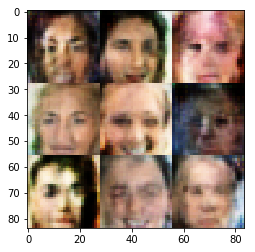

Epoch 1/1... Discriminator Loss: 2.5173... Generator Loss: 2.7395
Epoch 1/1... Discriminator Loss: 1.5646... Generator Loss: 0.5714
Epoch 1/1... Discriminator Loss: 1.3952... Generator Loss: 0.6516
Epoch 1/1... Discriminator Loss: 1.2685... Generator Loss: 1.3554
Epoch 1/1... Discriminator Loss: 1.4628... Generator Loss: 0.5913
Epoch 1/1... Discriminator Loss: 1.0293... Generator Loss: 1.5828
Epoch 1/1... Discriminator Loss: 1.5164... Generator Loss: 0.5835
Epoch 1/1... Discriminator Loss: 0.8623... Generator Loss: 1.7922
Epoch 1/1... Discriminator Loss: 1.1586... Generator Loss: 0.7479
Epoch 1/1... Discriminator Loss: 0.8618... Generator Loss: 1.1867
Epoch 1/1... Discriminator Loss: 0.9099... Generator Loss: 1.3338
Epoch 1/1... Discriminator Loss: 1.6855... Generator Loss: 0.4368
Epoch 1/1... Discriminator Loss: 1.8035... Generator Loss: 2.3224
Epoch 1/1... Discriminator Loss: 1.3242... Generator Loss: 0.6273
Epoch 1/1... Discriminator Loss: 1.1119... Generator Loss: 1.3075
Epoch 1/1.

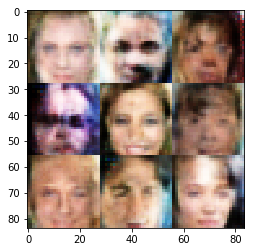

Epoch 1/1... Discriminator Loss: 0.7243... Generator Loss: 1.2042
Epoch 1/1... Discriminator Loss: 1.9239... Generator Loss: 0.3996
Epoch 1/1... Discriminator Loss: 2.0620... Generator Loss: 2.0876
Epoch 1/1... Discriminator Loss: 1.2844... Generator Loss: 0.7077
Epoch 1/1... Discriminator Loss: 1.0849... Generator Loss: 0.7693
Epoch 1/1... Discriminator Loss: 1.0802... Generator Loss: 1.4785
Epoch 1/1... Discriminator Loss: 1.0396... Generator Loss: 0.8905
Epoch 1/1... Discriminator Loss: 1.5122... Generator Loss: 0.5192
Epoch 1/1... Discriminator Loss: 1.2122... Generator Loss: 0.8705
Epoch 1/1... Discriminator Loss: 1.3812... Generator Loss: 0.6004
Epoch 1/1... Discriminator Loss: 1.1551... Generator Loss: 0.8623
Epoch 1/1... Discriminator Loss: 0.7789... Generator Loss: 1.8293
Epoch 1/1... Discriminator Loss: 1.2623... Generator Loss: 0.5944
Epoch 1/1... Discriminator Loss: 1.0376... Generator Loss: 1.0351
Epoch 1/1... Discriminator Loss: 0.9564... Generator Loss: 1.0018
Epoch 1/1.

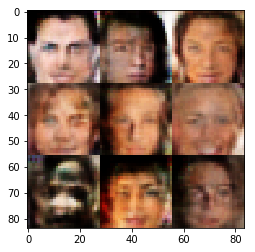

Epoch 1/1... Discriminator Loss: 1.0096... Generator Loss: 0.9426
Epoch 1/1... Discriminator Loss: 0.7488... Generator Loss: 1.8113
Epoch 1/1... Discriminator Loss: 1.4151... Generator Loss: 0.5201
Epoch 1/1... Discriminator Loss: 1.0307... Generator Loss: 1.5255
Epoch 1/1... Discriminator Loss: 1.2937... Generator Loss: 0.6265
Epoch 1/1... Discriminator Loss: 0.9211... Generator Loss: 1.4273
Epoch 1/1... Discriminator Loss: 1.5857... Generator Loss: 0.4694
Epoch 1/1... Discriminator Loss: 1.1309... Generator Loss: 1.3650
Epoch 1/1... Discriminator Loss: 1.1336... Generator Loss: 0.7206
Epoch 1/1... Discriminator Loss: 1.0606... Generator Loss: 1.1285
Epoch 1/1... Discriminator Loss: 1.1614... Generator Loss: 0.7411
Epoch 1/1... Discriminator Loss: 1.1241... Generator Loss: 0.8243
Epoch 1/1... Discriminator Loss: 0.6248... Generator Loss: 2.1700
Epoch 1/1... Discriminator Loss: 0.8550... Generator Loss: 1.0238
Epoch 1/1... Discriminator Loss: 1.0415... Generator Loss: 0.7685
Epoch 1/1.

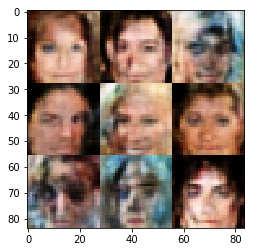

Epoch 1/1... Discriminator Loss: 1.7616... Generator Loss: 0.4101
Epoch 1/1... Discriminator Loss: 1.2852... Generator Loss: 1.1048
Epoch 1/1... Discriminator Loss: 1.1532... Generator Loss: 0.7131
Epoch 1/1... Discriminator Loss: 1.2207... Generator Loss: 0.6404
Epoch 1/1... Discriminator Loss: 0.9686... Generator Loss: 1.6913
Epoch 1/1... Discriminator Loss: 1.3463... Generator Loss: 0.5913
Epoch 1/1... Discriminator Loss: 0.9746... Generator Loss: 0.9472
Epoch 1/1... Discriminator Loss: 0.8356... Generator Loss: 1.0274
Epoch 1/1... Discriminator Loss: 0.9481... Generator Loss: 0.8684
Epoch 1/1... Discriminator Loss: 1.0296... Generator Loss: 1.8165
Epoch 1/1... Discriminator Loss: 0.7309... Generator Loss: 1.2355
Epoch 1/1... Discriminator Loss: 0.9083... Generator Loss: 0.9565
Epoch 1/1... Discriminator Loss: 1.3950... Generator Loss: 0.5322
Epoch 1/1... Discriminator Loss: 1.1788... Generator Loss: 1.1129
Epoch 1/1... Discriminator Loss: 1.2380... Generator Loss: 0.6218
Epoch 1/1.

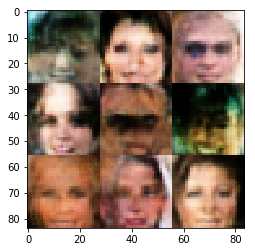

Epoch 1/1... Discriminator Loss: 1.1084... Generator Loss: 0.7392
Epoch 1/1... Discriminator Loss: 0.9198... Generator Loss: 0.9138
Epoch 1/1... Discriminator Loss: 1.1473... Generator Loss: 1.6099
Epoch 1/1... Discriminator Loss: 1.7110... Generator Loss: 0.4404
Epoch 1/1... Discriminator Loss: 1.3096... Generator Loss: 1.6644
Epoch 1/1... Discriminator Loss: 1.6507... Generator Loss: 0.4471
Epoch 1/1... Discriminator Loss: 0.9469... Generator Loss: 1.7849
Epoch 1/1... Discriminator Loss: 0.9418... Generator Loss: 0.9742
Epoch 1/1... Discriminator Loss: 1.0338... Generator Loss: 0.9361
Epoch 1/1... Discriminator Loss: 0.6246... Generator Loss: 1.7193
Epoch 1/1... Discriminator Loss: 0.9111... Generator Loss: 0.8729
Epoch 1/1... Discriminator Loss: 1.1555... Generator Loss: 1.0355
Epoch 1/1... Discriminator Loss: 0.8584... Generator Loss: 0.9726
Epoch 1/1... Discriminator Loss: 0.8019... Generator Loss: 1.3507
Epoch 1/1... Discriminator Loss: 0.9137... Generator Loss: 1.1257
Epoch 1/1.

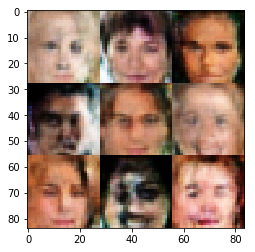

Epoch 1/1... Discriminator Loss: 1.5369... Generator Loss: 0.4809
Epoch 1/1... Discriminator Loss: 0.9959... Generator Loss: 1.3116
Epoch 1/1... Discriminator Loss: 1.2052... Generator Loss: 0.6488
Epoch 1/1... Discriminator Loss: 0.6852... Generator Loss: 1.5742
Epoch 1/1... Discriminator Loss: 1.1237... Generator Loss: 0.7218
Epoch 1/1... Discriminator Loss: 1.2384... Generator Loss: 1.5633
Epoch 1/1... Discriminator Loss: 1.7272... Generator Loss: 0.4276
Epoch 1/1... Discriminator Loss: 1.6193... Generator Loss: 1.9884
Epoch 1/1... Discriminator Loss: 1.1636... Generator Loss: 0.7157
Epoch 1/1... Discriminator Loss: 1.4431... Generator Loss: 0.5451
Epoch 1/1... Discriminator Loss: 1.1538... Generator Loss: 1.1808
Epoch 1/1... Discriminator Loss: 1.2791... Generator Loss: 0.7392
Epoch 1/1... Discriminator Loss: 0.8699... Generator Loss: 1.2966
Epoch 1/1... Discriminator Loss: 0.6512... Generator Loss: 1.5911
Epoch 1/1... Discriminator Loss: 1.4716... Generator Loss: 0.4945
Epoch 1/1.

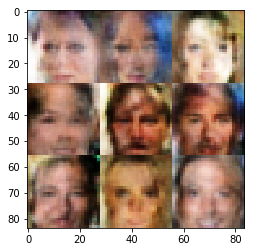

Epoch 1/1... Discriminator Loss: 1.0991... Generator Loss: 0.7187
Epoch 1/1... Discriminator Loss: 1.1184... Generator Loss: 1.3273
Epoch 1/1... Discriminator Loss: 0.9320... Generator Loss: 0.8882
Epoch 1/1... Discriminator Loss: 0.9359... Generator Loss: 0.9497
Epoch 1/1... Discriminator Loss: 0.9842... Generator Loss: 1.0327
Epoch 1/1... Discriminator Loss: 0.7239... Generator Loss: 1.3196
Epoch 1/1... Discriminator Loss: 0.6782... Generator Loss: 1.2710
Epoch 1/1... Discriminator Loss: 1.0530... Generator Loss: 0.7434
Epoch 1/1... Discriminator Loss: 0.8757... Generator Loss: 1.5350
Epoch 1/1... Discriminator Loss: 1.0250... Generator Loss: 1.4248
Epoch 1/1... Discriminator Loss: 1.5801... Generator Loss: 0.4823
Epoch 1/1... Discriminator Loss: 1.4652... Generator Loss: 1.8106
Epoch 1/1... Discriminator Loss: 1.8169... Generator Loss: 0.4051
Epoch 1/1... Discriminator Loss: 1.4678... Generator Loss: 1.4861
Epoch 1/1... Discriminator Loss: 1.3596... Generator Loss: 0.6305
Epoch 1/1.

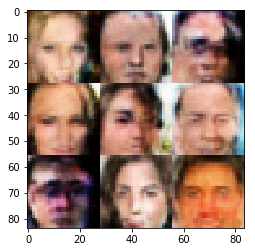

Epoch 1/1... Discriminator Loss: 1.1823... Generator Loss: 1.1806
Epoch 1/1... Discriminator Loss: 1.3902... Generator Loss: 0.5503
Epoch 1/1... Discriminator Loss: 0.7929... Generator Loss: 1.5552
Epoch 1/1... Discriminator Loss: 1.2249... Generator Loss: 0.6304
Epoch 1/1... Discriminator Loss: 1.0344... Generator Loss: 1.2516
Epoch 1/1... Discriminator Loss: 0.7053... Generator Loss: 1.2870
Epoch 1/1... Discriminator Loss: 1.0608... Generator Loss: 0.7169
Epoch 1/1... Discriminator Loss: 0.8654... Generator Loss: 1.4537
Epoch 1/1... Discriminator Loss: 1.0527... Generator Loss: 1.0658
Epoch 1/1... Discriminator Loss: 0.8850... Generator Loss: 0.9529
Epoch 1/1... Discriminator Loss: 1.2129... Generator Loss: 1.1679
Epoch 1/1... Discriminator Loss: 1.6236... Generator Loss: 0.4808
Epoch 1/1... Discriminator Loss: 1.0086... Generator Loss: 1.6352
Epoch 1/1... Discriminator Loss: 1.0092... Generator Loss: 0.8307
Epoch 1/1... Discriminator Loss: 1.0079... Generator Loss: 0.8165
Epoch 1/1.

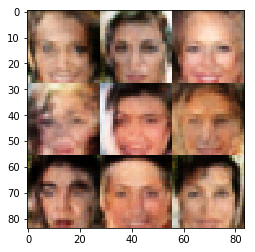

Epoch 1/1... Discriminator Loss: 1.2740... Generator Loss: 0.9068
Epoch 1/1... Discriminator Loss: 1.0516... Generator Loss: 1.1028
Epoch 1/1... Discriminator Loss: 1.1634... Generator Loss: 0.7376
Epoch 1/1... Discriminator Loss: 1.1092... Generator Loss: 1.0251
Epoch 1/1... Discriminator Loss: 1.1691... Generator Loss: 0.8150
Epoch 1/1... Discriminator Loss: 1.1544... Generator Loss: 0.7083
Epoch 1/1... Discriminator Loss: 0.6034... Generator Loss: 1.8213
Epoch 1/1... Discriminator Loss: 1.5273... Generator Loss: 0.4897
Epoch 1/1... Discriminator Loss: 1.4240... Generator Loss: 2.0023
Epoch 1/1... Discriminator Loss: 1.2775... Generator Loss: 0.6315
Epoch 1/1... Discriminator Loss: 1.1101... Generator Loss: 0.7269
Epoch 1/1... Discriminator Loss: 1.0072... Generator Loss: 1.3846
Epoch 1/1... Discriminator Loss: 1.6139... Generator Loss: 0.4571
Epoch 1/1... Discriminator Loss: 1.3052... Generator Loss: 0.6974
Epoch 1/1... Discriminator Loss: 1.1749... Generator Loss: 0.7908
Epoch 1/1.

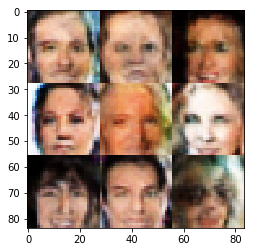

Epoch 1/1... Discriminator Loss: 1.1373... Generator Loss: 0.9421
Epoch 1/1... Discriminator Loss: 1.2349... Generator Loss: 0.6658
Epoch 1/1... Discriminator Loss: 1.0745... Generator Loss: 0.8898
Epoch 1/1... Discriminator Loss: 1.1561... Generator Loss: 0.7950
Epoch 1/1... Discriminator Loss: 1.0208... Generator Loss: 0.9706
Epoch 1/1... Discriminator Loss: 0.8655... Generator Loss: 1.2335
Epoch 1/1... Discriminator Loss: 0.8685... Generator Loss: 1.0052
Epoch 1/1... Discriminator Loss: 1.1447... Generator Loss: 0.6748
Epoch 1/1... Discriminator Loss: 0.8799... Generator Loss: 1.6212
Epoch 1/1... Discriminator Loss: 1.1721... Generator Loss: 0.7333
Epoch 1/1... Discriminator Loss: 0.9172... Generator Loss: 0.9069
Epoch 1/1... Discriminator Loss: 1.3049... Generator Loss: 0.7820
Epoch 1/1... Discriminator Loss: 0.9013... Generator Loss: 1.4780
Epoch 1/1... Discriminator Loss: 1.3751... Generator Loss: 0.5283
Epoch 1/1... Discriminator Loss: 0.9079... Generator Loss: 1.7949
Epoch 1/1.

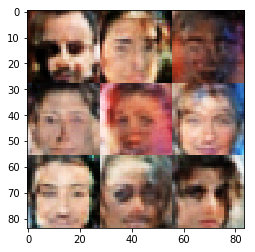

Epoch 1/1... Discriminator Loss: 1.2252... Generator Loss: 0.6764
Epoch 1/1... Discriminator Loss: 1.2462... Generator Loss: 0.6046
Epoch 1/1... Discriminator Loss: 1.1269... Generator Loss: 1.1647
Epoch 1/1... Discriminator Loss: 1.1765... Generator Loss: 0.6434
Epoch 1/1... Discriminator Loss: 1.1195... Generator Loss: 1.0692
Epoch 1/1... Discriminator Loss: 1.0728... Generator Loss: 0.7457
Epoch 1/1... Discriminator Loss: 0.9201... Generator Loss: 1.3016
Epoch 1/1... Discriminator Loss: 0.9721... Generator Loss: 0.8512
Epoch 1/1... Discriminator Loss: 1.3482... Generator Loss: 0.9514
Epoch 1/1... Discriminator Loss: 2.0654... Generator Loss: 0.3674
Epoch 1/1... Discriminator Loss: 1.5518... Generator Loss: 1.6327
Epoch 1/1... Discriminator Loss: 1.2106... Generator Loss: 0.7176
Epoch 1/1... Discriminator Loss: 1.4301... Generator Loss: 0.5416
Epoch 1/1... Discriminator Loss: 1.2321... Generator Loss: 1.2493
Epoch 1/1... Discriminator Loss: 1.1642... Generator Loss: 0.6548
Epoch 1/1.

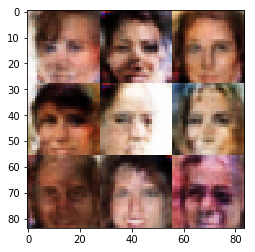

Epoch 1/1... Discriminator Loss: 0.9458... Generator Loss: 0.8752
Epoch 1/1... Discriminator Loss: 0.9010... Generator Loss: 1.0398
Epoch 1/1... Discriminator Loss: 1.0739... Generator Loss: 0.7961
Epoch 1/1... Discriminator Loss: 1.1372... Generator Loss: 0.7565
Epoch 1/1... Discriminator Loss: 1.3010... Generator Loss: 1.1406
Epoch 1/1... Discriminator Loss: 1.7328... Generator Loss: 0.4212
Epoch 1/1... Discriminator Loss: 1.8531... Generator Loss: 2.4164
Epoch 1/1... Discriminator Loss: 1.3040... Generator Loss: 0.6548
Epoch 1/1... Discriminator Loss: 1.2351... Generator Loss: 0.6649
Epoch 1/1... Discriminator Loss: 1.0762... Generator Loss: 1.1629
Epoch 1/1... Discriminator Loss: 1.2240... Generator Loss: 0.6113
Epoch 1/1... Discriminator Loss: 1.2443... Generator Loss: 1.0327
Epoch 1/1... Discriminator Loss: 1.0335... Generator Loss: 0.8060
Epoch 1/1... Discriminator Loss: 0.5479... Generator Loss: 2.2205
Epoch 1/1... Discriminator Loss: 1.2363... Generator Loss: 0.6362
Epoch 1/1.

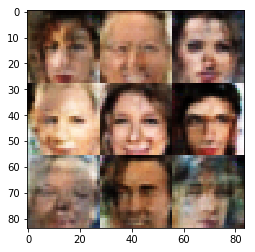

Epoch 1/1... Discriminator Loss: 1.3345... Generator Loss: 1.4590
Epoch 1/1... Discriminator Loss: 1.4089... Generator Loss: 0.5257
Epoch 1/1... Discriminator Loss: 1.2347... Generator Loss: 0.9074
Epoch 1/1... Discriminator Loss: 1.4286... Generator Loss: 0.5238
Epoch 1/1... Discriminator Loss: 1.1332... Generator Loss: 1.1056
Epoch 1/1... Discriminator Loss: 1.1587... Generator Loss: 0.7265
Epoch 1/1... Discriminator Loss: 1.1596... Generator Loss: 0.7116
Epoch 1/1... Discriminator Loss: 1.0188... Generator Loss: 0.9996
Epoch 1/1... Discriminator Loss: 1.8365... Generator Loss: 0.4051
Epoch 1/1... Discriminator Loss: 0.9932... Generator Loss: 2.9795
Epoch 1/1... Discriminator Loss: 1.1061... Generator Loss: 0.7332
Epoch 1/1... Discriminator Loss: 0.9038... Generator Loss: 1.0225
Epoch 1/1... Discriminator Loss: 1.4519... Generator Loss: 0.5074
Epoch 1/1... Discriminator Loss: 1.0957... Generator Loss: 0.8747
Epoch 1/1... Discriminator Loss: 1.2656... Generator Loss: 0.7602
Epoch 1/1.

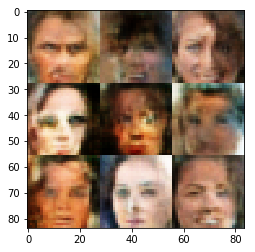

Epoch 1/1... Discriminator Loss: 1.2449... Generator Loss: 0.6532
Epoch 1/1... Discriminator Loss: 1.1609... Generator Loss: 0.9267
Epoch 1/1... Discriminator Loss: 1.0905... Generator Loss: 0.8468
Epoch 1/1... Discriminator Loss: 1.1665... Generator Loss: 0.8695
Epoch 1/1... Discriminator Loss: 1.4807... Generator Loss: 0.4959
Epoch 1/1... Discriminator Loss: 1.2533... Generator Loss: 1.3285
Epoch 1/1... Discriminator Loss: 1.2617... Generator Loss: 0.5941
Epoch 1/1... Discriminator Loss: 1.2222... Generator Loss: 0.7157
Epoch 1/1... Discriminator Loss: 1.2094... Generator Loss: 1.1347
Epoch 1/1... Discriminator Loss: 1.1195... Generator Loss: 0.7647
Epoch 1/1... Discriminator Loss: 1.1557... Generator Loss: 0.7178
Epoch 1/1... Discriminator Loss: 1.4099... Generator Loss: 0.7628
Epoch 1/1... Discriminator Loss: 1.2749... Generator Loss: 0.6280
Epoch 1/1... Discriminator Loss: 1.4861... Generator Loss: 0.5416
Epoch 1/1... Discriminator Loss: 1.0986... Generator Loss: 1.0706
Epoch 1/1.

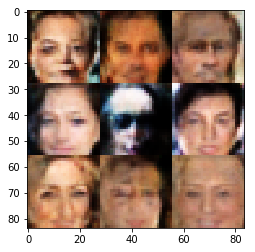

Epoch 1/1... Discriminator Loss: 1.2972... Generator Loss: 0.8964
Epoch 1/1... Discriminator Loss: 1.1671... Generator Loss: 0.7760
Epoch 1/1... Discriminator Loss: 0.9330... Generator Loss: 0.8863
Epoch 1/1... Discriminator Loss: 1.1892... Generator Loss: 0.7228
Epoch 1/1... Discriminator Loss: 1.4814... Generator Loss: 0.5622
Epoch 1/1... Discriminator Loss: 1.4215... Generator Loss: 0.5379
Epoch 1/1... Discriminator Loss: 1.0470... Generator Loss: 1.7630
Epoch 1/1... Discriminator Loss: 1.5427... Generator Loss: 0.5067
Epoch 1/1... Discriminator Loss: 1.2390... Generator Loss: 0.9195
Epoch 1/1... Discriminator Loss: 1.5238... Generator Loss: 0.5274
Epoch 1/1... Discriminator Loss: 1.2491... Generator Loss: 1.0372
Epoch 1/1... Discriminator Loss: 1.2941... Generator Loss: 0.6372
Epoch 1/1... Discriminator Loss: 0.9244... Generator Loss: 0.9317
Epoch 1/1... Discriminator Loss: 0.9439... Generator Loss: 0.8577
Epoch 1/1... Discriminator Loss: 1.2015... Generator Loss: 1.1740
Epoch 1/1.

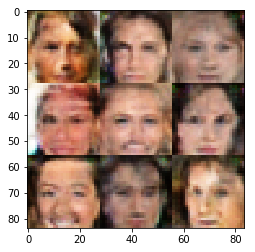

Epoch 1/1... Discriminator Loss: 1.3976... Generator Loss: 0.5404
Epoch 1/1... Discriminator Loss: 0.9675... Generator Loss: 1.4186
Epoch 1/1... Discriminator Loss: 1.1853... Generator Loss: 0.7004
Epoch 1/1... Discriminator Loss: 1.2305... Generator Loss: 0.6737
Epoch 1/1... Discriminator Loss: 1.2320... Generator Loss: 1.2676
Epoch 1/1... Discriminator Loss: 1.2245... Generator Loss: 0.6364
Epoch 1/1... Discriminator Loss: 1.0092... Generator Loss: 0.8971
Epoch 1/1... Discriminator Loss: 1.1159... Generator Loss: 0.8124
Epoch 1/1... Discriminator Loss: 1.2893... Generator Loss: 0.6373
Epoch 1/1... Discriminator Loss: 1.2848... Generator Loss: 0.6821
Epoch 1/1... Discriminator Loss: 1.0540... Generator Loss: 1.4195
Epoch 1/1... Discriminator Loss: 1.1493... Generator Loss: 0.6788
Epoch 1/1... Discriminator Loss: 1.1460... Generator Loss: 0.9200
Epoch 1/1... Discriminator Loss: 1.4901... Generator Loss: 0.5342
Epoch 1/1... Discriminator Loss: 1.3014... Generator Loss: 0.8546
Epoch 1/1.

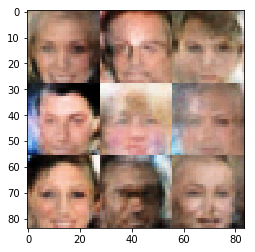

Epoch 1/1... Discriminator Loss: 1.4249... Generator Loss: 0.5993
Epoch 1/1... Discriminator Loss: 1.2681... Generator Loss: 1.1548
Epoch 1/1... Discriminator Loss: 1.1775... Generator Loss: 0.8380
Epoch 1/1... Discriminator Loss: 1.2476... Generator Loss: 0.7054
Epoch 1/1... Discriminator Loss: 1.1441... Generator Loss: 0.7945
Epoch 1/1... Discriminator Loss: 1.4303... Generator Loss: 0.5781
Epoch 1/1... Discriminator Loss: 1.3772... Generator Loss: 0.5422
Epoch 1/1... Discriminator Loss: 1.2014... Generator Loss: 1.2439
Epoch 1/1... Discriminator Loss: 0.9820... Generator Loss: 0.9001
Epoch 1/1... Discriminator Loss: 1.2773... Generator Loss: 0.6111
Epoch 1/1... Discriminator Loss: 0.8595... Generator Loss: 1.2746
Epoch 1/1... Discriminator Loss: 1.3827... Generator Loss: 0.5847
Epoch 1/1... Discriminator Loss: 1.1254... Generator Loss: 0.9679
Epoch 1/1... Discriminator Loss: 1.3986... Generator Loss: 0.5438
Epoch 1/1... Discriminator Loss: 1.1988... Generator Loss: 1.0938
Epoch 1/1.

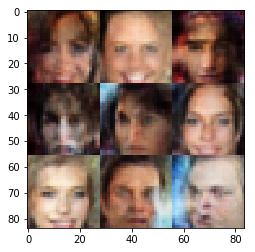

Epoch 1/1... Discriminator Loss: 1.2011... Generator Loss: 0.7060
Epoch 1/1... Discriminator Loss: 0.8104... Generator Loss: 1.4956
Epoch 1/1... Discriminator Loss: 1.7161... Generator Loss: 0.4415
Epoch 1/1... Discriminator Loss: 1.2292... Generator Loss: 1.2299
Epoch 1/1... Discriminator Loss: 1.3691... Generator Loss: 0.5447
Epoch 1/1... Discriminator Loss: 1.0456... Generator Loss: 1.2805
Epoch 1/1... Discriminator Loss: 1.1831... Generator Loss: 0.6483
Epoch 1/1... Discriminator Loss: 1.1889... Generator Loss: 0.9194
Epoch 1/1... Discriminator Loss: 1.0638... Generator Loss: 0.7509
Epoch 1/1... Discriminator Loss: 0.7463... Generator Loss: 1.3770
Epoch 1/1... Discriminator Loss: 1.2407... Generator Loss: 0.6233
Epoch 1/1... Discriminator Loss: 1.1389... Generator Loss: 1.4092
Epoch 1/1... Discriminator Loss: 1.2085... Generator Loss: 0.7193
Epoch 1/1... Discriminator Loss: 1.1938... Generator Loss: 0.7162
Epoch 1/1... Discriminator Loss: 1.2109... Generator Loss: 0.6758
Epoch 1/1.

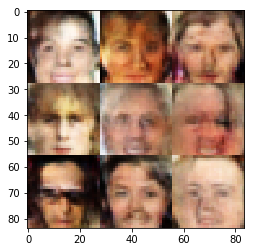

Epoch 1/1... Discriminator Loss: 1.3464... Generator Loss: 1.4242
Epoch 1/1... Discriminator Loss: 1.6979... Generator Loss: 0.4480
Epoch 1/1... Discriminator Loss: 1.4231... Generator Loss: 1.6161
Epoch 1/1... Discriminator Loss: 1.2306... Generator Loss: 0.7021
Epoch 1/1... Discriminator Loss: 1.2380... Generator Loss: 0.7104
Epoch 1/1... Discriminator Loss: 1.0961... Generator Loss: 1.2864
Epoch 1/1... Discriminator Loss: 1.2243... Generator Loss: 0.7130
Epoch 1/1... Discriminator Loss: 1.2639... Generator Loss: 0.6473
Epoch 1/1... Discriminator Loss: 0.8970... Generator Loss: 1.3097
Epoch 1/1... Discriminator Loss: 1.4489... Generator Loss: 0.5328
Epoch 1/1... Discriminator Loss: 1.1240... Generator Loss: 1.0835
Epoch 1/1... Discriminator Loss: 1.8420... Generator Loss: 0.3882
Epoch 1/1... Discriminator Loss: 1.0733... Generator Loss: 1.5754
Epoch 1/1... Discriminator Loss: 0.8469... Generator Loss: 1.0749
Epoch 1/1... Discriminator Loss: 1.4195... Generator Loss: 0.5771
Epoch 1/1.

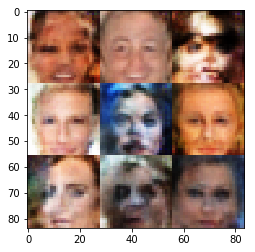

Epoch 1/1... Discriminator Loss: 0.7621... Generator Loss: 1.3344
Epoch 1/1... Discriminator Loss: 1.3201... Generator Loss: 0.5824
Epoch 1/1... Discriminator Loss: 1.5256... Generator Loss: 1.4441
Epoch 1/1... Discriminator Loss: 1.9099... Generator Loss: 0.3958
Epoch 1/1... Discriminator Loss: 1.3972... Generator Loss: 1.3536
Epoch 1/1... Discriminator Loss: 1.3291... Generator Loss: 0.6091
Epoch 1/1... Discriminator Loss: 1.3554... Generator Loss: 0.5629
Epoch 1/1... Discriminator Loss: 1.2696... Generator Loss: 0.9364
Epoch 1/1... Discriminator Loss: 1.4180... Generator Loss: 0.5094
Epoch 1/1... Discriminator Loss: 0.9936... Generator Loss: 1.0924
Epoch 1/1... Discriminator Loss: 1.0819... Generator Loss: 0.7485
Epoch 1/1... Discriminator Loss: 1.2585... Generator Loss: 0.7149
Epoch 1/1... Discriminator Loss: 1.0277... Generator Loss: 1.6486
Epoch 1/1... Discriminator Loss: 1.2657... Generator Loss: 0.6195
Epoch 1/1... Discriminator Loss: 0.9424... Generator Loss: 1.0045
Epoch 1/1.

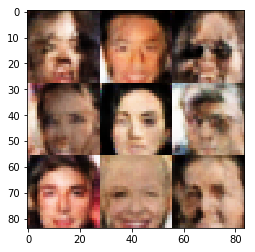

Epoch 1/1... Discriminator Loss: 1.0819... Generator Loss: 1.3019
Epoch 1/1... Discriminator Loss: 1.0838... Generator Loss: 0.8681
Epoch 1/1... Discriminator Loss: 1.3477... Generator Loss: 0.5422
Epoch 1/1... Discriminator Loss: 1.1742... Generator Loss: 1.0444
Epoch 1/1... Discriminator Loss: 0.7172... Generator Loss: 1.5556
Epoch 1/1... Discriminator Loss: 1.3285... Generator Loss: 0.5687
Epoch 1/1... Discriminator Loss: 1.4227... Generator Loss: 0.6549
Epoch 1/1... Discriminator Loss: 1.2729... Generator Loss: 0.7662
Epoch 1/1... Discriminator Loss: 1.3106... Generator Loss: 0.5776
Epoch 1/1... Discriminator Loss: 1.1866... Generator Loss: 1.0210
Epoch 1/1... Discriminator Loss: 1.1882... Generator Loss: 0.6594
Epoch 1/1... Discriminator Loss: 1.2041... Generator Loss: 0.7491
Epoch 1/1... Discriminator Loss: 1.2643... Generator Loss: 1.0667
Epoch 1/1... Discriminator Loss: 1.7169... Generator Loss: 0.4324
Epoch 1/1... Discriminator Loss: 1.1168... Generator Loss: 1.3239
Epoch 1/1.

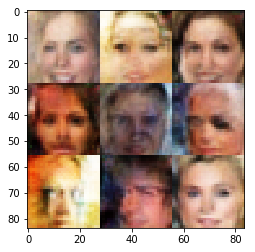

Epoch 1/1... Discriminator Loss: 1.4078... Generator Loss: 1.2935
Epoch 1/1... Discriminator Loss: 1.3706... Generator Loss: 0.5962
Epoch 1/1... Discriminator Loss: 0.7836... Generator Loss: 1.3302
Epoch 1/1... Discriminator Loss: 1.3791... Generator Loss: 0.5421
Epoch 1/1... Discriminator Loss: 1.1100... Generator Loss: 0.8450
Epoch 1/1... Discriminator Loss: 1.0737... Generator Loss: 0.9448
Epoch 1/1... Discriminator Loss: 1.0354... Generator Loss: 0.8652
Epoch 1/1... Discriminator Loss: 1.2396... Generator Loss: 0.6447
Epoch 1/1... Discriminator Loss: 1.3336... Generator Loss: 0.6378
Epoch 1/1... Discriminator Loss: 1.2548... Generator Loss: 0.7508
Epoch 1/1... Discriminator Loss: 1.4334... Generator Loss: 0.5523
Epoch 1/1... Discriminator Loss: 1.3109... Generator Loss: 1.1740
Epoch 1/1... Discriminator Loss: 1.4972... Generator Loss: 0.4923
Epoch 1/1... Discriminator Loss: 1.1464... Generator Loss: 0.8990
Epoch 1/1... Discriminator Loss: 1.3651... Generator Loss: 0.5956
Epoch 1/1.

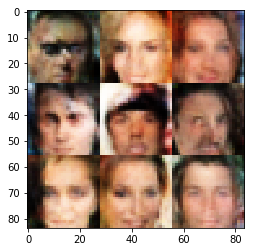

Epoch 1/1... Discriminator Loss: 0.7564... Generator Loss: 1.2111
Epoch 1/1... Discriminator Loss: 1.5250... Generator Loss: 0.5049
Epoch 1/1... Discriminator Loss: 1.1808... Generator Loss: 1.3373
Epoch 1/1... Discriminator Loss: 1.1681... Generator Loss: 0.7403
Epoch 1/1... Discriminator Loss: 1.1851... Generator Loss: 0.6838
Epoch 1/1... Discriminator Loss: 1.2582... Generator Loss: 0.6363
Epoch 1/1... Discriminator Loss: 1.2758... Generator Loss: 0.7200
Epoch 1/1... Discriminator Loss: 0.9939... Generator Loss: 0.9068
Epoch 1/1... Discriminator Loss: 1.3520... Generator Loss: 0.5651
Epoch 1/1... Discriminator Loss: 1.4074... Generator Loss: 1.1306
Epoch 1/1... Discriminator Loss: 1.5499... Generator Loss: 0.4967
Epoch 1/1... Discriminator Loss: 1.1303... Generator Loss: 1.2097
Epoch 1/1... Discriminator Loss: 1.1412... Generator Loss: 0.6753
Epoch 1/1... Discriminator Loss: 1.2196... Generator Loss: 0.7621
Epoch 1/1... Discriminator Loss: 1.1842... Generator Loss: 0.7171
Epoch 1/1.

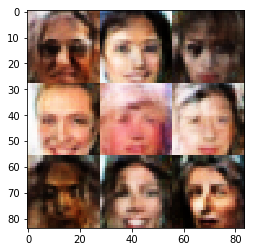

Epoch 1/1... Discriminator Loss: 1.3189... Generator Loss: 0.5819
Epoch 1/1... Discriminator Loss: 1.1421... Generator Loss: 0.7733
Epoch 1/1... Discriminator Loss: 1.0215... Generator Loss: 1.0008
Epoch 1/1... Discriminator Loss: 1.2739... Generator Loss: 0.6890
Epoch 1/1... Discriminator Loss: 1.5525... Generator Loss: 0.4781
Epoch 1/1... Discriminator Loss: 1.1355... Generator Loss: 1.2654
Epoch 1/1... Discriminator Loss: 1.2268... Generator Loss: 0.6977
Epoch 1/1... Discriminator Loss: 1.2309... Generator Loss: 0.6485
Epoch 1/1... Discriminator Loss: 1.0592... Generator Loss: 1.0033
Epoch 1/1... Discriminator Loss: 1.5184... Generator Loss: 0.4762
Epoch 1/1... Discriminator Loss: 1.1715... Generator Loss: 1.4896
Epoch 1/1... Discriminator Loss: 1.4099... Generator Loss: 0.5437
Epoch 1/1... Discriminator Loss: 1.0450... Generator Loss: 0.8656
Epoch 1/1... Discriminator Loss: 1.2052... Generator Loss: 0.8376
Epoch 1/1... Discriminator Loss: 1.3891... Generator Loss: 0.5877
Epoch 1/1.

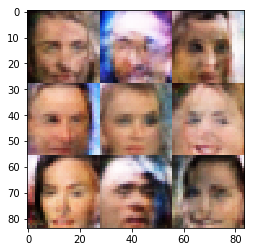

Epoch 1/1... Discriminator Loss: 0.9817... Generator Loss: 1.1579
Epoch 1/1... Discriminator Loss: 1.4130... Generator Loss: 0.5658
Epoch 1/1... Discriminator Loss: 1.5667... Generator Loss: 0.7955
Epoch 1/1... Discriminator Loss: 1.1156... Generator Loss: 0.7152
Epoch 1/1... Discriminator Loss: 1.5803... Generator Loss: 0.5008
Epoch 1/1... Discriminator Loss: 1.3066... Generator Loss: 0.5815
Epoch 1/1... Discriminator Loss: 1.2175... Generator Loss: 0.9498
Epoch 1/1... Discriminator Loss: 1.0826... Generator Loss: 0.7441
Epoch 1/1... Discriminator Loss: 0.9265... Generator Loss: 1.0367
Epoch 1/1... Discriminator Loss: 1.4739... Generator Loss: 0.5197
Epoch 1/1... Discriminator Loss: 0.9244... Generator Loss: 1.1260
Epoch 1/1... Discriminator Loss: 1.2670... Generator Loss: 0.6552
Epoch 1/1... Discriminator Loss: 1.3713... Generator Loss: 0.5614
Epoch 1/1... Discriminator Loss: 1.1052... Generator Loss: 1.5043
Epoch 1/1... Discriminator Loss: 1.6218... Generator Loss: 0.4672
Epoch 1/1.

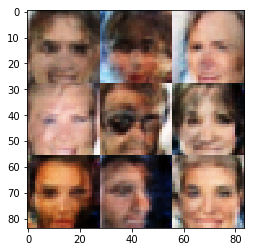

Epoch 1/1... Discriminator Loss: 1.2761... Generator Loss: 0.6008
Epoch 1/1... Discriminator Loss: 0.7692... Generator Loss: 1.7785
Epoch 1/1... Discriminator Loss: 1.7527... Generator Loss: 0.4460
Epoch 1/1... Discriminator Loss: 1.5918... Generator Loss: 1.7697
Epoch 1/1... Discriminator Loss: 1.6040... Generator Loss: 0.4590
Epoch 1/1... Discriminator Loss: 1.2189... Generator Loss: 1.1268
Epoch 1/1... Discriminator Loss: 1.3358... Generator Loss: 0.6172
Epoch 1/1... Discriminator Loss: 1.2206... Generator Loss: 0.6084
Epoch 1/1... Discriminator Loss: 1.2633... Generator Loss: 0.8074
Epoch 1/1... Discriminator Loss: 1.4099... Generator Loss: 0.6518
Epoch 1/1... Discriminator Loss: 1.5731... Generator Loss: 0.4717
Epoch 1/1... Discriminator Loss: 0.9680... Generator Loss: 1.1838
Epoch 1/1... Discriminator Loss: 1.2871... Generator Loss: 0.6148
Epoch 1/1... Discriminator Loss: 1.2245... Generator Loss: 0.7074
Epoch 1/1... Discriminator Loss: 1.0415... Generator Loss: 1.0807
Epoch 1/1.

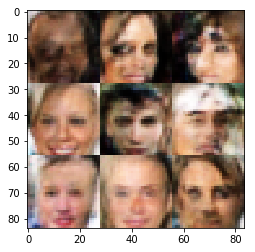

Epoch 1/1... Discriminator Loss: 1.1092... Generator Loss: 0.7066
Epoch 1/1... Discriminator Loss: 1.2620... Generator Loss: 0.7069
Epoch 1/1... Discriminator Loss: 1.1937... Generator Loss: 0.7776
Epoch 1/1... Discriminator Loss: 0.8581... Generator Loss: 1.0821
Epoch 1/1... Discriminator Loss: 1.1933... Generator Loss: 0.6625
Epoch 1/1... Discriminator Loss: 0.9089... Generator Loss: 1.1182
Epoch 1/1... Discriminator Loss: 1.1285... Generator Loss: 0.7657
Epoch 1/1... Discriminator Loss: 1.3029... Generator Loss: 0.6944
Epoch 1/1... Discriminator Loss: 1.3048... Generator Loss: 0.8580
Epoch 1/1... Discriminator Loss: 1.2786... Generator Loss: 0.5885
Epoch 1/1... Discriminator Loss: 1.1539... Generator Loss: 0.8868
Epoch 1/1... Discriminator Loss: 1.0859... Generator Loss: 1.2259
Epoch 1/1... Discriminator Loss: 1.3192... Generator Loss: 0.5639
Epoch 1/1... Discriminator Loss: 1.1235... Generator Loss: 0.9406
Epoch 1/1... Discriminator Loss: 1.4923... Generator Loss: 0.5345
Epoch 1/1.

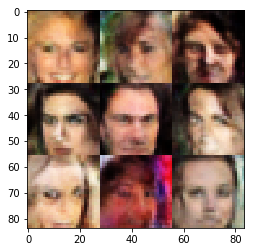

Epoch 1/1... Discriminator Loss: 1.2618... Generator Loss: 0.7982
Epoch 1/1... Discriminator Loss: 1.3861... Generator Loss: 0.5426
Epoch 1/1... Discriminator Loss: 1.1980... Generator Loss: 0.8456
Epoch 1/1... Discriminator Loss: 1.0017... Generator Loss: 1.0703
Epoch 1/1... Discriminator Loss: 1.5085... Generator Loss: 0.4756
Epoch 1/1... Discriminator Loss: 1.2699... Generator Loss: 1.0433
Epoch 1/1... Discriminator Loss: 1.2152... Generator Loss: 0.6799
Epoch 1/1... Discriminator Loss: 1.4248... Generator Loss: 0.5966
Epoch 1/1... Discriminator Loss: 1.5280... Generator Loss: 0.4992
Epoch 1/1... Discriminator Loss: 0.9595... Generator Loss: 1.7755
Epoch 1/1... Discriminator Loss: 1.2746... Generator Loss: 0.6197
Epoch 1/1... Discriminator Loss: 1.0661... Generator Loss: 0.9255
Epoch 1/1... Discriminator Loss: 1.5729... Generator Loss: 0.4850
Epoch 1/1... Discriminator Loss: 1.5224... Generator Loss: 1.8249
Epoch 1/1... Discriminator Loss: 1.6420... Generator Loss: 0.4545
Epoch 1/1.

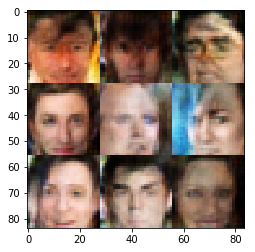

Epoch 1/1... Discriminator Loss: 1.1875... Generator Loss: 0.6785
Epoch 1/1... Discriminator Loss: 1.3419... Generator Loss: 0.7088
Epoch 1/1... Discriminator Loss: 1.0675... Generator Loss: 0.8723
Epoch 1/1... Discriminator Loss: 1.1892... Generator Loss: 0.7451
Epoch 1/1... Discriminator Loss: 1.2892... Generator Loss: 0.5853
Epoch 1/1... Discriminator Loss: 1.2618... Generator Loss: 1.3056
Epoch 1/1... Discriminator Loss: 1.3763... Generator Loss: 0.5683
Epoch 1/1... Discriminator Loss: 1.2827... Generator Loss: 0.7323
Epoch 1/1... Discriminator Loss: 1.1207... Generator Loss: 0.9399
Epoch 1/1... Discriminator Loss: 1.2810... Generator Loss: 0.6095
Epoch 1/1... Discriminator Loss: 1.1692... Generator Loss: 0.8309
Epoch 1/1... Discriminator Loss: 1.3673... Generator Loss: 0.6927
Epoch 1/1... Discriminator Loss: 1.2039... Generator Loss: 0.7926
Epoch 1/1... Discriminator Loss: 1.3304... Generator Loss: 0.6426
Epoch 1/1... Discriminator Loss: 1.0405... Generator Loss: 0.9590
Epoch 1/1.

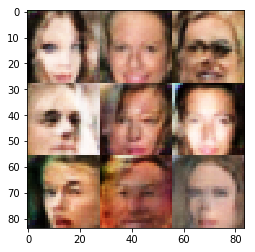

Epoch 1/1... Discriminator Loss: 1.0181... Generator Loss: 0.8028
Epoch 1/1... Discriminator Loss: 1.1451... Generator Loss: 1.1197
Epoch 1/1... Discriminator Loss: 1.4787... Generator Loss: 0.4949
Epoch 1/1... Discriminator Loss: 1.1006... Generator Loss: 1.3863
Epoch 1/1... Discriminator Loss: 1.2413... Generator Loss: 0.6397
Epoch 1/1... Discriminator Loss: 1.1083... Generator Loss: 0.7977
Epoch 1/1... Discriminator Loss: 1.0361... Generator Loss: 0.8267
Epoch 1/1... Discriminator Loss: 0.9641... Generator Loss: 1.3170
Epoch 1/1... Discriminator Loss: 1.4320... Generator Loss: 0.5211
Epoch 1/1... Discriminator Loss: 1.1773... Generator Loss: 1.3628
Epoch 1/1... Discriminator Loss: 1.2146... Generator Loss: 0.6540
Epoch 1/1... Discriminator Loss: 1.3630... Generator Loss: 0.5896
Epoch 1/1... Discriminator Loss: 1.3246... Generator Loss: 0.8137
Epoch 1/1... Discriminator Loss: 1.3074... Generator Loss: 0.5609
Epoch 1/1... Discriminator Loss: 1.2372... Generator Loss: 1.0602
Epoch 1/1.

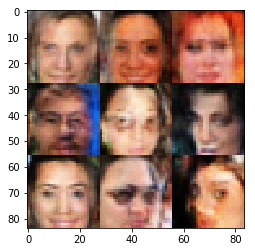

Epoch 1/1... Discriminator Loss: 1.1331... Generator Loss: 0.6924
Epoch 1/1... Discriminator Loss: 1.2121... Generator Loss: 0.7066
Epoch 1/1... Discriminator Loss: 1.1249... Generator Loss: 0.7944
Epoch 1/1... Discriminator Loss: 0.9737... Generator Loss: 0.9559
Epoch 1/1... Discriminator Loss: 1.3357... Generator Loss: 0.5679
Epoch 1/1... Discriminator Loss: 1.2593... Generator Loss: 0.9652
Epoch 1/1... Discriminator Loss: 1.3202... Generator Loss: 0.5959
Epoch 1/1... Discriminator Loss: 1.0286... Generator Loss: 0.8413
Epoch 1/1... Discriminator Loss: 1.3397... Generator Loss: 0.6415
Epoch 1/1... Discriminator Loss: 1.0654... Generator Loss: 1.0665
Epoch 1/1... Discriminator Loss: 1.0530... Generator Loss: 0.7632
Epoch 1/1... Discriminator Loss: 1.0969... Generator Loss: 0.8004
Epoch 1/1... Discriminator Loss: 1.1683... Generator Loss: 0.7083
Epoch 1/1... Discriminator Loss: 1.2208... Generator Loss: 1.0848
Epoch 1/1... Discriminator Loss: 1.4492... Generator Loss: 0.5287
Epoch 1/1.

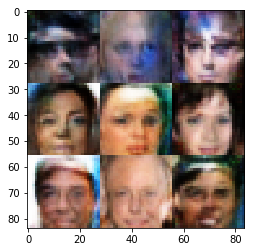

Epoch 1/1... Discriminator Loss: 1.2400... Generator Loss: 0.6624
Epoch 1/1... Discriminator Loss: 1.1950... Generator Loss: 0.6979
Epoch 1/1... Discriminator Loss: 0.8014... Generator Loss: 1.7403
Epoch 1/1... Discriminator Loss: 1.5635... Generator Loss: 0.4711
Epoch 1/1... Discriminator Loss: 0.9688... Generator Loss: 1.1055
Epoch 1/1... Discriminator Loss: 1.3736... Generator Loss: 0.5739
Epoch 1/1... Discriminator Loss: 1.1425... Generator Loss: 0.8718
Epoch 1/1... Discriminator Loss: 1.3047... Generator Loss: 0.6465
Epoch 1/1... Discriminator Loss: 1.2849... Generator Loss: 0.6691
Epoch 1/1... Discriminator Loss: 1.1763... Generator Loss: 1.2600
Epoch 1/1... Discriminator Loss: 1.5522... Generator Loss: 0.4609
Epoch 1/1... Discriminator Loss: 1.0604... Generator Loss: 0.9577
Epoch 1/1... Discriminator Loss: 1.2119... Generator Loss: 0.8375
Epoch 1/1... Discriminator Loss: 1.2203... Generator Loss: 0.6557
Epoch 1/1... Discriminator Loss: 1.1682... Generator Loss: 0.8042
Epoch 1/1.

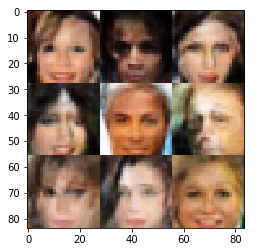

Epoch 1/1... Discriminator Loss: 1.1500... Generator Loss: 0.8662
Epoch 1/1... Discriminator Loss: 1.2456... Generator Loss: 0.8258
Epoch 1/1... Discriminator Loss: 1.1292... Generator Loss: 0.7654
Epoch 1/1... Discriminator Loss: 1.4061... Generator Loss: 0.5645
Epoch 1/1... Discriminator Loss: 1.0985... Generator Loss: 1.0546
Epoch 1/1... Discriminator Loss: 1.2106... Generator Loss: 0.6369
Epoch 1/1... Discriminator Loss: 1.1106... Generator Loss: 1.3266
Epoch 1/1... Discriminator Loss: 1.2086... Generator Loss: 0.6384
Epoch 1/1... Discriminator Loss: 1.0848... Generator Loss: 1.1949
Epoch 1/1... Discriminator Loss: 1.2998... Generator Loss: 0.5700
Epoch 1/1... Discriminator Loss: 1.1966... Generator Loss: 0.8318
Epoch 1/1... Discriminator Loss: 1.1567... Generator Loss: 0.8163
Epoch 1/1... Discriminator Loss: 1.3477... Generator Loss: 0.5999
Epoch 1/1... Discriminator Loss: 1.2244... Generator Loss: 0.9886
Epoch 1/1... Discriminator Loss: 1.1621... Generator Loss: 0.8406
Epoch 1/1.

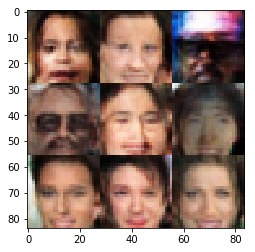

Epoch 1/1... Discriminator Loss: 1.2718... Generator Loss: 0.8988
Epoch 1/1... Discriminator Loss: 1.2332... Generator Loss: 0.6623
Epoch 1/1... Discriminator Loss: 1.3361... Generator Loss: 1.4207
Epoch 1/1... Discriminator Loss: 1.5193... Generator Loss: 0.4806
Epoch 1/1... Discriminator Loss: 1.3228... Generator Loss: 1.5926
Epoch 1/1... Discriminator Loss: 1.4046... Generator Loss: 0.5569
Epoch 1/1... Discriminator Loss: 1.3020... Generator Loss: 0.6521
Epoch 1/1... Discriminator Loss: 1.0355... Generator Loss: 1.1327
Epoch 1/1... Discriminator Loss: 1.5215... Generator Loss: 0.5005
Epoch 1/1... Discriminator Loss: 1.6243... Generator Loss: 1.2569
Epoch 1/1... Discriminator Loss: 1.5414... Generator Loss: 0.4765
Epoch 1/1... Discriminator Loss: 1.2450... Generator Loss: 0.9348
Epoch 1/1... Discriminator Loss: 1.1265... Generator Loss: 0.7468
Epoch 1/1... Discriminator Loss: 1.3416... Generator Loss: 0.6203
Epoch 1/1... Discriminator Loss: 0.7607... Generator Loss: 1.7004
Epoch 1/1.

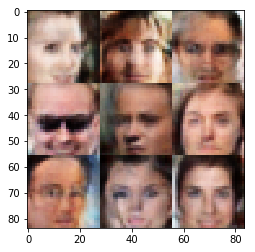

Epoch 1/1... Discriminator Loss: 1.2313... Generator Loss: 0.7257
Epoch 1/1... Discriminator Loss: 1.1362... Generator Loss: 0.7194
Epoch 1/1... Discriminator Loss: 1.1247... Generator Loss: 1.1167
Epoch 1/1... Discriminator Loss: 1.4873... Generator Loss: 0.4909
Epoch 1/1... Discriminator Loss: 1.1340... Generator Loss: 1.0757
Epoch 1/1... Discriminator Loss: 1.1640... Generator Loss: 0.7433
Epoch 1/1... Discriminator Loss: 1.3404... Generator Loss: 0.5682
Epoch 1/1... Discriminator Loss: 1.3197... Generator Loss: 0.6633
Epoch 1/1... Discriminator Loss: 1.3018... Generator Loss: 0.8158
Epoch 1/1... Discriminator Loss: 1.4086... Generator Loss: 0.5090
Epoch 1/1... Discriminator Loss: 1.0613... Generator Loss: 1.1495
Epoch 1/1... Discriminator Loss: 1.1618... Generator Loss: 0.7342
Epoch 1/1... Discriminator Loss: 1.1431... Generator Loss: 0.7583
Epoch 1/1... Discriminator Loss: 0.8209... Generator Loss: 1.4553
Epoch 1/1... Discriminator Loss: 1.2376... Generator Loss: 0.6363
Epoch 1/1.

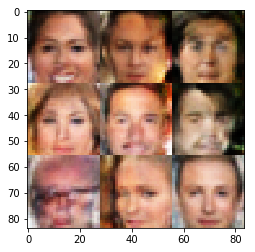

Epoch 1/1... Discriminator Loss: 1.0329... Generator Loss: 0.8583
Epoch 1/1... Discriminator Loss: 1.5365... Generator Loss: 0.4662
Epoch 1/1... Discriminator Loss: 1.1508... Generator Loss: 1.0140
Epoch 1/1... Discriminator Loss: 1.2226... Generator Loss: 0.7823
Epoch 1/1... Discriminator Loss: 1.5436... Generator Loss: 0.4793
Epoch 1/1... Discriminator Loss: 1.2622... Generator Loss: 1.2353
Epoch 1/1... Discriminator Loss: 1.5775... Generator Loss: 0.4607
Epoch 1/1... Discriminator Loss: 1.1763... Generator Loss: 1.1573
Epoch 1/1... Discriminator Loss: 1.2857... Generator Loss: 0.6190
Epoch 1/1... Discriminator Loss: 1.0927... Generator Loss: 1.0832
Epoch 1/1... Discriminator Loss: 1.3635... Generator Loss: 0.5692
Epoch 1/1... Discriminator Loss: 1.1273... Generator Loss: 1.2395
Epoch 1/1... Discriminator Loss: 1.2422... Generator Loss: 0.6249
Epoch 1/1... Discriminator Loss: 1.1838... Generator Loss: 0.7676
Epoch 1/1... Discriminator Loss: 1.1592... Generator Loss: 0.8451
Epoch 1/1.

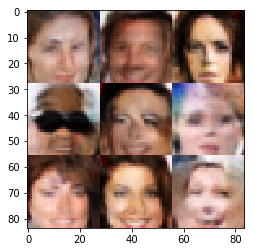

Epoch 1/1... Discriminator Loss: 1.2199... Generator Loss: 1.0883
Epoch 1/1... Discriminator Loss: 1.2836... Generator Loss: 0.6005
Epoch 1/1... Discriminator Loss: 1.2007... Generator Loss: 0.8017
Epoch 1/1... Discriminator Loss: 1.1614... Generator Loss: 0.8898
Epoch 1/1... Discriminator Loss: 1.5931... Generator Loss: 0.4646
Epoch 1/1... Discriminator Loss: 1.0636... Generator Loss: 1.0509
Epoch 1/1... Discriminator Loss: 1.0237... Generator Loss: 1.0638
Epoch 1/1... Discriminator Loss: 1.3458... Generator Loss: 0.5550
Epoch 1/1... Discriminator Loss: 1.4006... Generator Loss: 0.7415
Epoch 1/1... Discriminator Loss: 1.1372... Generator Loss: 0.8567
Epoch 1/1... Discriminator Loss: 1.3696... Generator Loss: 0.5814
Epoch 1/1... Discriminator Loss: 1.2490... Generator Loss: 0.8449
Epoch 1/1... Discriminator Loss: 1.4355... Generator Loss: 0.5370
Epoch 1/1... Discriminator Loss: 1.3991... Generator Loss: 1.2979
Epoch 1/1... Discriminator Loss: 1.3985... Generator Loss: 0.5553
Epoch 1/1.

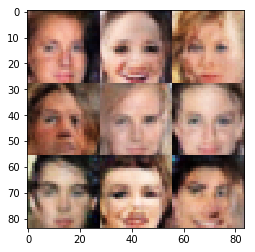

Epoch 1/1... Discriminator Loss: 1.1650... Generator Loss: 1.1111
Epoch 1/1... Discriminator Loss: 1.3752... Generator Loss: 0.5632
Epoch 1/1... Discriminator Loss: 1.2485... Generator Loss: 0.7885
Epoch 1/1... Discriminator Loss: 1.0190... Generator Loss: 0.8837
Epoch 1/1... Discriminator Loss: 1.2236... Generator Loss: 0.9346
Epoch 1/1... Discriminator Loss: 1.2369... Generator Loss: 0.6589
Epoch 1/1... Discriminator Loss: 1.0453... Generator Loss: 0.9105
Epoch 1/1... Discriminator Loss: 1.2054... Generator Loss: 0.7338
Epoch 1/1... Discriminator Loss: 0.9643... Generator Loss: 1.0307
Epoch 1/1... Discriminator Loss: 1.4253... Generator Loss: 0.5313
Epoch 1/1... Discriminator Loss: 1.3575... Generator Loss: 0.8354
Epoch 1/1... Discriminator Loss: 1.2108... Generator Loss: 0.8233
Epoch 1/1... Discriminator Loss: 1.3493... Generator Loss: 0.5716
Epoch 1/1... Discriminator Loss: 1.1793... Generator Loss: 0.9533
Epoch 1/1... Discriminator Loss: 1.4197... Generator Loss: 0.5184
Epoch 1/1.

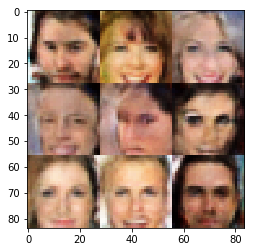

Epoch 1/1... Discriminator Loss: 1.1111... Generator Loss: 0.7159
Epoch 1/1... Discriminator Loss: 1.1247... Generator Loss: 0.8440
Epoch 1/1... Discriminator Loss: 1.1161... Generator Loss: 0.7815
Epoch 1/1... Discriminator Loss: 1.2542... Generator Loss: 0.7183
Epoch 1/1... Discriminator Loss: 1.4266... Generator Loss: 0.5237
Epoch 1/1... Discriminator Loss: 1.0314... Generator Loss: 1.2417
Epoch 1/1... Discriminator Loss: 1.0570... Generator Loss: 0.7758
Epoch 1/1... Discriminator Loss: 1.1554... Generator Loss: 0.7153
Epoch 1/1... Discriminator Loss: 1.1577... Generator Loss: 0.7696
Epoch 1/1... Discriminator Loss: 0.9038... Generator Loss: 1.1063
Epoch 1/1... Discriminator Loss: 1.3462... Generator Loss: 0.5718
Epoch 1/1... Discriminator Loss: 1.2270... Generator Loss: 0.7412
Epoch 1/1... Discriminator Loss: 1.3521... Generator Loss: 0.5968
Epoch 1/1... Discriminator Loss: 1.2490... Generator Loss: 1.0059
Epoch 1/1... Discriminator Loss: 1.3096... Generator Loss: 0.5912
Epoch 1/1.

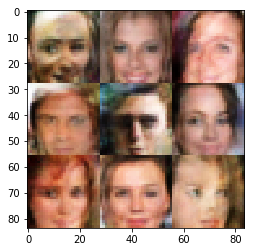

Epoch 1/1... Discriminator Loss: 1.1476... Generator Loss: 0.8608
Epoch 1/1... Discriminator Loss: 1.3203... Generator Loss: 0.6103
Epoch 1/1... Discriminator Loss: 1.2519... Generator Loss: 0.9639
Epoch 1/1... Discriminator Loss: 1.3370... Generator Loss: 0.5530
Epoch 1/1... Discriminator Loss: 1.1397... Generator Loss: 1.1657
Epoch 1/1... Discriminator Loss: 1.3358... Generator Loss: 0.5912
Epoch 1/1... Discriminator Loss: 1.2529... Generator Loss: 0.7522
Epoch 1/1... Discriminator Loss: 1.0126... Generator Loss: 0.9919
Epoch 1/1... Discriminator Loss: 1.5262... Generator Loss: 0.4937
Epoch 1/1... Discriminator Loss: 1.3315... Generator Loss: 1.5587
Epoch 1/1... Discriminator Loss: 1.2762... Generator Loss: 0.6652
Epoch 1/1... Discriminator Loss: 1.1522... Generator Loss: 0.7592
Epoch 1/1... Discriminator Loss: 0.9262... Generator Loss: 1.1227
Epoch 1/1... Discriminator Loss: 1.3202... Generator Loss: 0.5873
Epoch 1/1... Discriminator Loss: 1.1469... Generator Loss: 0.8351
Epoch 1/1.

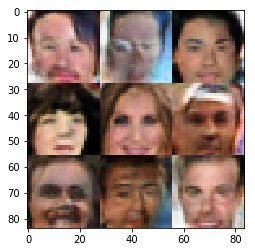

Epoch 1/1... Discriminator Loss: 1.3871... Generator Loss: 0.5929
Epoch 1/1... Discriminator Loss: 1.2680... Generator Loss: 0.7502
Epoch 1/1... Discriminator Loss: 1.2232... Generator Loss: 0.7649
Epoch 1/1... Discriminator Loss: 1.1861... Generator Loss: 0.7765
Epoch 1/1... Discriminator Loss: 1.4061... Generator Loss: 0.5436
Epoch 1/1... Discriminator Loss: 1.1449... Generator Loss: 0.9590
Epoch 1/1... Discriminator Loss: 1.2068... Generator Loss: 0.6645
Epoch 1/1... Discriminator Loss: 1.2398... Generator Loss: 0.6893
Epoch 1/1... Discriminator Loss: 1.2195... Generator Loss: 1.0703
Epoch 1/1... Discriminator Loss: 1.2145... Generator Loss: 0.6544
Epoch 1/1... Discriminator Loss: 1.0192... Generator Loss: 1.1622
Epoch 1/1... Discriminator Loss: 1.3500... Generator Loss: 0.5719
Epoch 1/1... Discriminator Loss: 1.2686... Generator Loss: 0.9150
Epoch 1/1... Discriminator Loss: 1.2067... Generator Loss: 0.7142
Epoch 1/1... Discriminator Loss: 1.2037... Generator Loss: 0.7168
Epoch 1/1.

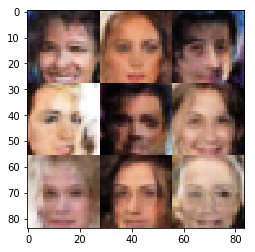

Epoch 1/1... Discriminator Loss: 1.2671... Generator Loss: 0.7228
Epoch 1/1... Discriminator Loss: 1.0596... Generator Loss: 0.7828
Epoch 1/1... Discriminator Loss: 1.1999... Generator Loss: 0.7949
Epoch 1/1... Discriminator Loss: 1.3213... Generator Loss: 0.6397
Epoch 1/1... Discriminator Loss: 1.4940... Generator Loss: 0.4853
Epoch 1/1... Discriminator Loss: 1.3725... Generator Loss: 1.0523
Epoch 1/1... Discriminator Loss: 1.2743... Generator Loss: 0.6192
Epoch 1/1... Discriminator Loss: 1.1108... Generator Loss: 1.1208
Epoch 1/1... Discriminator Loss: 1.2907... Generator Loss: 0.6219
Epoch 1/1... Discriminator Loss: 1.2894... Generator Loss: 0.8176
Epoch 1/1... Discriminator Loss: 1.1470... Generator Loss: 0.7054
Epoch 1/1... Discriminator Loss: 1.1592... Generator Loss: 0.7300
Epoch 1/1... Discriminator Loss: 1.1527... Generator Loss: 0.8883
Epoch 1/1... Discriminator Loss: 1.1959... Generator Loss: 0.7547
Epoch 1/1... Discriminator Loss: 1.0126... Generator Loss: 0.8749
Epoch 1/1.

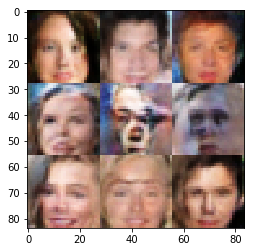

Epoch 1/1... Discriminator Loss: 1.3189... Generator Loss: 0.7389
Epoch 1/1... Discriminator Loss: 1.2577... Generator Loss: 0.6980
Epoch 1/1... Discriminator Loss: 1.3626... Generator Loss: 0.5898
Epoch 1/1... Discriminator Loss: 1.1468... Generator Loss: 0.8993
Epoch 1/1... Discriminator Loss: 1.0809... Generator Loss: 0.7705
Epoch 1/1... Discriminator Loss: 1.3809... Generator Loss: 0.5930
Epoch 1/1... Discriminator Loss: 1.0882... Generator Loss: 0.8767
Epoch 1/1... Discriminator Loss: 1.2052... Generator Loss: 0.7020
Epoch 1/1... Discriminator Loss: 1.2037... Generator Loss: 0.6868
Epoch 1/1... Discriminator Loss: 1.1785... Generator Loss: 1.0051
Epoch 1/1... Discriminator Loss: 1.0544... Generator Loss: 0.7669
Epoch 1/1... Discriminator Loss: 1.1236... Generator Loss: 0.8186
Epoch 1/1... Discriminator Loss: 1.2353... Generator Loss: 0.7845
Epoch 1/1... Discriminator Loss: 1.3834... Generator Loss: 0.5914
Epoch 1/1... Discriminator Loss: 1.2150... Generator Loss: 0.8417
Epoch 1/1.

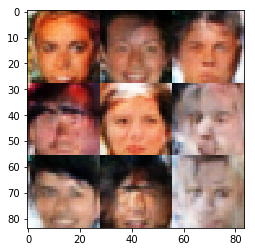

Epoch 1/1... Discriminator Loss: 1.4398... Generator Loss: 0.5114
Epoch 1/1... Discriminator Loss: 1.1883... Generator Loss: 1.0223
Epoch 1/1... Discriminator Loss: 1.4026... Generator Loss: 0.5676
Epoch 1/1... Discriminator Loss: 1.1429... Generator Loss: 0.9061
Epoch 1/1... Discriminator Loss: 1.1011... Generator Loss: 0.7667
Epoch 1/1... Discriminator Loss: 1.3025... Generator Loss: 0.7112
Epoch 1/1... Discriminator Loss: 1.1834... Generator Loss: 0.7601
Epoch 1/1... Discriminator Loss: 1.3049... Generator Loss: 0.6500
Epoch 1/1... Discriminator Loss: 1.1428... Generator Loss: 0.7552
Epoch 1/1... Discriminator Loss: 1.1035... Generator Loss: 0.9273
Epoch 1/1... Discriminator Loss: 1.2982... Generator Loss: 0.5968
Epoch 1/1... Discriminator Loss: 1.2177... Generator Loss: 0.9350
Epoch 1/1... Discriminator Loss: 1.3410... Generator Loss: 0.5577
Epoch 1/1... Discriminator Loss: 1.3816... Generator Loss: 0.6270
Epoch 1/1... Discriminator Loss: 1.0590... Generator Loss: 0.9527
Epoch 1/1.

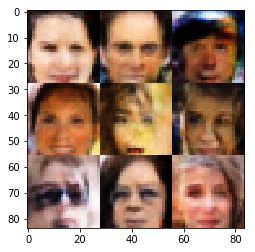

Epoch 1/1... Discriminator Loss: 1.3755... Generator Loss: 0.6078
Epoch 1/1... Discriminator Loss: 1.3666... Generator Loss: 0.6327
Epoch 1/1... Discriminator Loss: 1.1417... Generator Loss: 0.7795
Epoch 1/1... Discriminator Loss: 1.2878... Generator Loss: 0.6464
Epoch 1/1... Discriminator Loss: 1.5006... Generator Loss: 0.5065
Epoch 1/1... Discriminator Loss: 1.2535... Generator Loss: 1.1404
Epoch 1/1... Discriminator Loss: 1.5003... Generator Loss: 0.5008
Epoch 1/1... Discriminator Loss: 1.3714... Generator Loss: 0.5813
Epoch 1/1... Discriminator Loss: 1.3407... Generator Loss: 1.3016
Epoch 1/1... Discriminator Loss: 1.3982... Generator Loss: 0.5402
Epoch 1/1... Discriminator Loss: 1.3982... Generator Loss: 0.6261
Epoch 1/1... Discriminator Loss: 1.3347... Generator Loss: 0.8281
Epoch 1/1... Discriminator Loss: 1.2982... Generator Loss: 0.6632
Epoch 1/1... Discriminator Loss: 1.1746... Generator Loss: 0.7119
Epoch 1/1... Discriminator Loss: 1.0211... Generator Loss: 1.2381
Epoch 1/1.

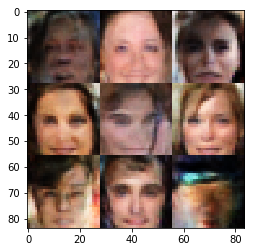

Epoch 1/1... Discriminator Loss: 1.3578... Generator Loss: 0.6257
Epoch 1/1... Discriminator Loss: 1.2579... Generator Loss: 0.6885
Epoch 1/1... Discriminator Loss: 1.1157... Generator Loss: 1.1409
Epoch 1/1... Discriminator Loss: 1.3982... Generator Loss: 0.5447
Epoch 1/1... Discriminator Loss: 1.2388... Generator Loss: 0.6974
Epoch 1/1... Discriminator Loss: 1.1169... Generator Loss: 0.8474
Epoch 1/1... Discriminator Loss: 1.1099... Generator Loss: 0.8312
Epoch 1/1... Discriminator Loss: 1.2174... Generator Loss: 0.8061
Epoch 1/1... Discriminator Loss: 1.2659... Generator Loss: 0.6409
Epoch 1/1... Discriminator Loss: 1.2164... Generator Loss: 0.7487
Epoch 1/1... Discriminator Loss: 1.0405... Generator Loss: 0.9890
Epoch 1/1... Discriminator Loss: 1.1227... Generator Loss: 0.6719
Epoch 1/1... Discriminator Loss: 1.1282... Generator Loss: 0.8473
Epoch 1/1... Discriminator Loss: 1.1502... Generator Loss: 0.7826
Epoch 1/1... Discriminator Loss: 1.3456... Generator Loss: 0.6091
Epoch 1/1.

In [33]:

batch_size = 32
z_dim = 100
learning_rate = 0.0005
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### 提交项目
提交本项目前，确保运行所有 cells 后保存该文件。

保存该文件为 "dlnd_face_generation.ipynb"， 并另存为 HTML 格式 "File" -> "Download as"。提交项目时请附带 "helper.py" 和 "problem_unittests.py" 文件。